In [1]:
import pandas as pd
import numpy as np

In [3]:
prom_file_path = "surf_labeled.parquet"

In [4]:
prom_df = pd.read_parquet(prom_file_path)

In [4]:
prom_df

,timestamp,node,node_load15,node_load1,node_load5,node_memory_Active_bytes,nvidia_gpu_power_usage_milliwatts-max,isAnomaly
0,1577833200,r10n1,3.40,3.44,3.99,1.140718e+10,0.0,0
1,1577833215,r10n1,3.40,3.44,3.99,1.140718e+10,0.0,0
2,1577833230,r10n1,3.32,2.47,3.71,1.140702e+10,0.0,0
3,1577833245,r10n1,3.32,2.47,3.71,1.140702e+10,0.0,0
4,1577833260,r10n1,3.28,2.37,3.56,1.135940e+10,0.0,0
...,...,...,...,...,...,...,...,...
135476345,1585864035,r38n2,0.01,0.13,0.04,1.091813e+09,0.0,0
135476346,1585864050,r38n2,0.01,0.08,0.04,1.091785e+09,0.0,0
135476347,1585864065,r38n2,0.01,0.08,0.04,1.091785e+09,0.0,0
135476348,1585864080,r38n2,0.01,0.05,0.03,1.091785e+09,0.0,0


In [5]:

total_rows = prom_df.shape[0]
print("prom_df 总共有 {} 行".format(total_rows))

anomaly_rows = prom_df[prom_df['isAnomaly'] == 1].shape[0]
print("isAnomaly为1的有 {} 行".format(anomaly_rows))

percentage = (anomaly_rows / total_rows) * 100
print("isAnomaly为1的占比为 {:.2f}%".format(percentage))

prom_df 总共有 131170780 行
isAnomaly为1的有 3814028 行
isAnomaly为1的占比为 2.91%


In [5]:
sorted_df = prom_df.sort_values(by=['timestamp', 'node', 'isAnomaly'], ascending=[True, True, False])
dedup_df = sorted_df.drop_duplicates(subset=['timestamp', 'node'])

dedup_df['timestamp'] = pd.to_datetime(dedup_df['timestamp'], unit='s')

dedup_df.set_index('timestamp', inplace=True)

resampled_df = dedup_df.groupby('node').resample('D').mean().reset_index()

/tmp/ipykernel_608825/2255501040.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dedup_df['timestamp'] = pd.to_datetime(dedup_df['timestamp'], unit='s')
/tmp/ipykernel_608825/2255501040.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = dedup_df.groupby('node').resample('D').mean().reset_index()


In [6]:
import matplotlib.colors as mcolors
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
pivot_df = resampled_df.pivot(columns='timestamp', index='node', values='isAnomaly')

pivot_df.columns = pivot_df.columns.strftime('%m-%d')

anomaly_df = pivot_df.copy()
anomaly_df[anomaly_df < 1] = np.nan

/tmp/ipykernel_608825/280438329.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


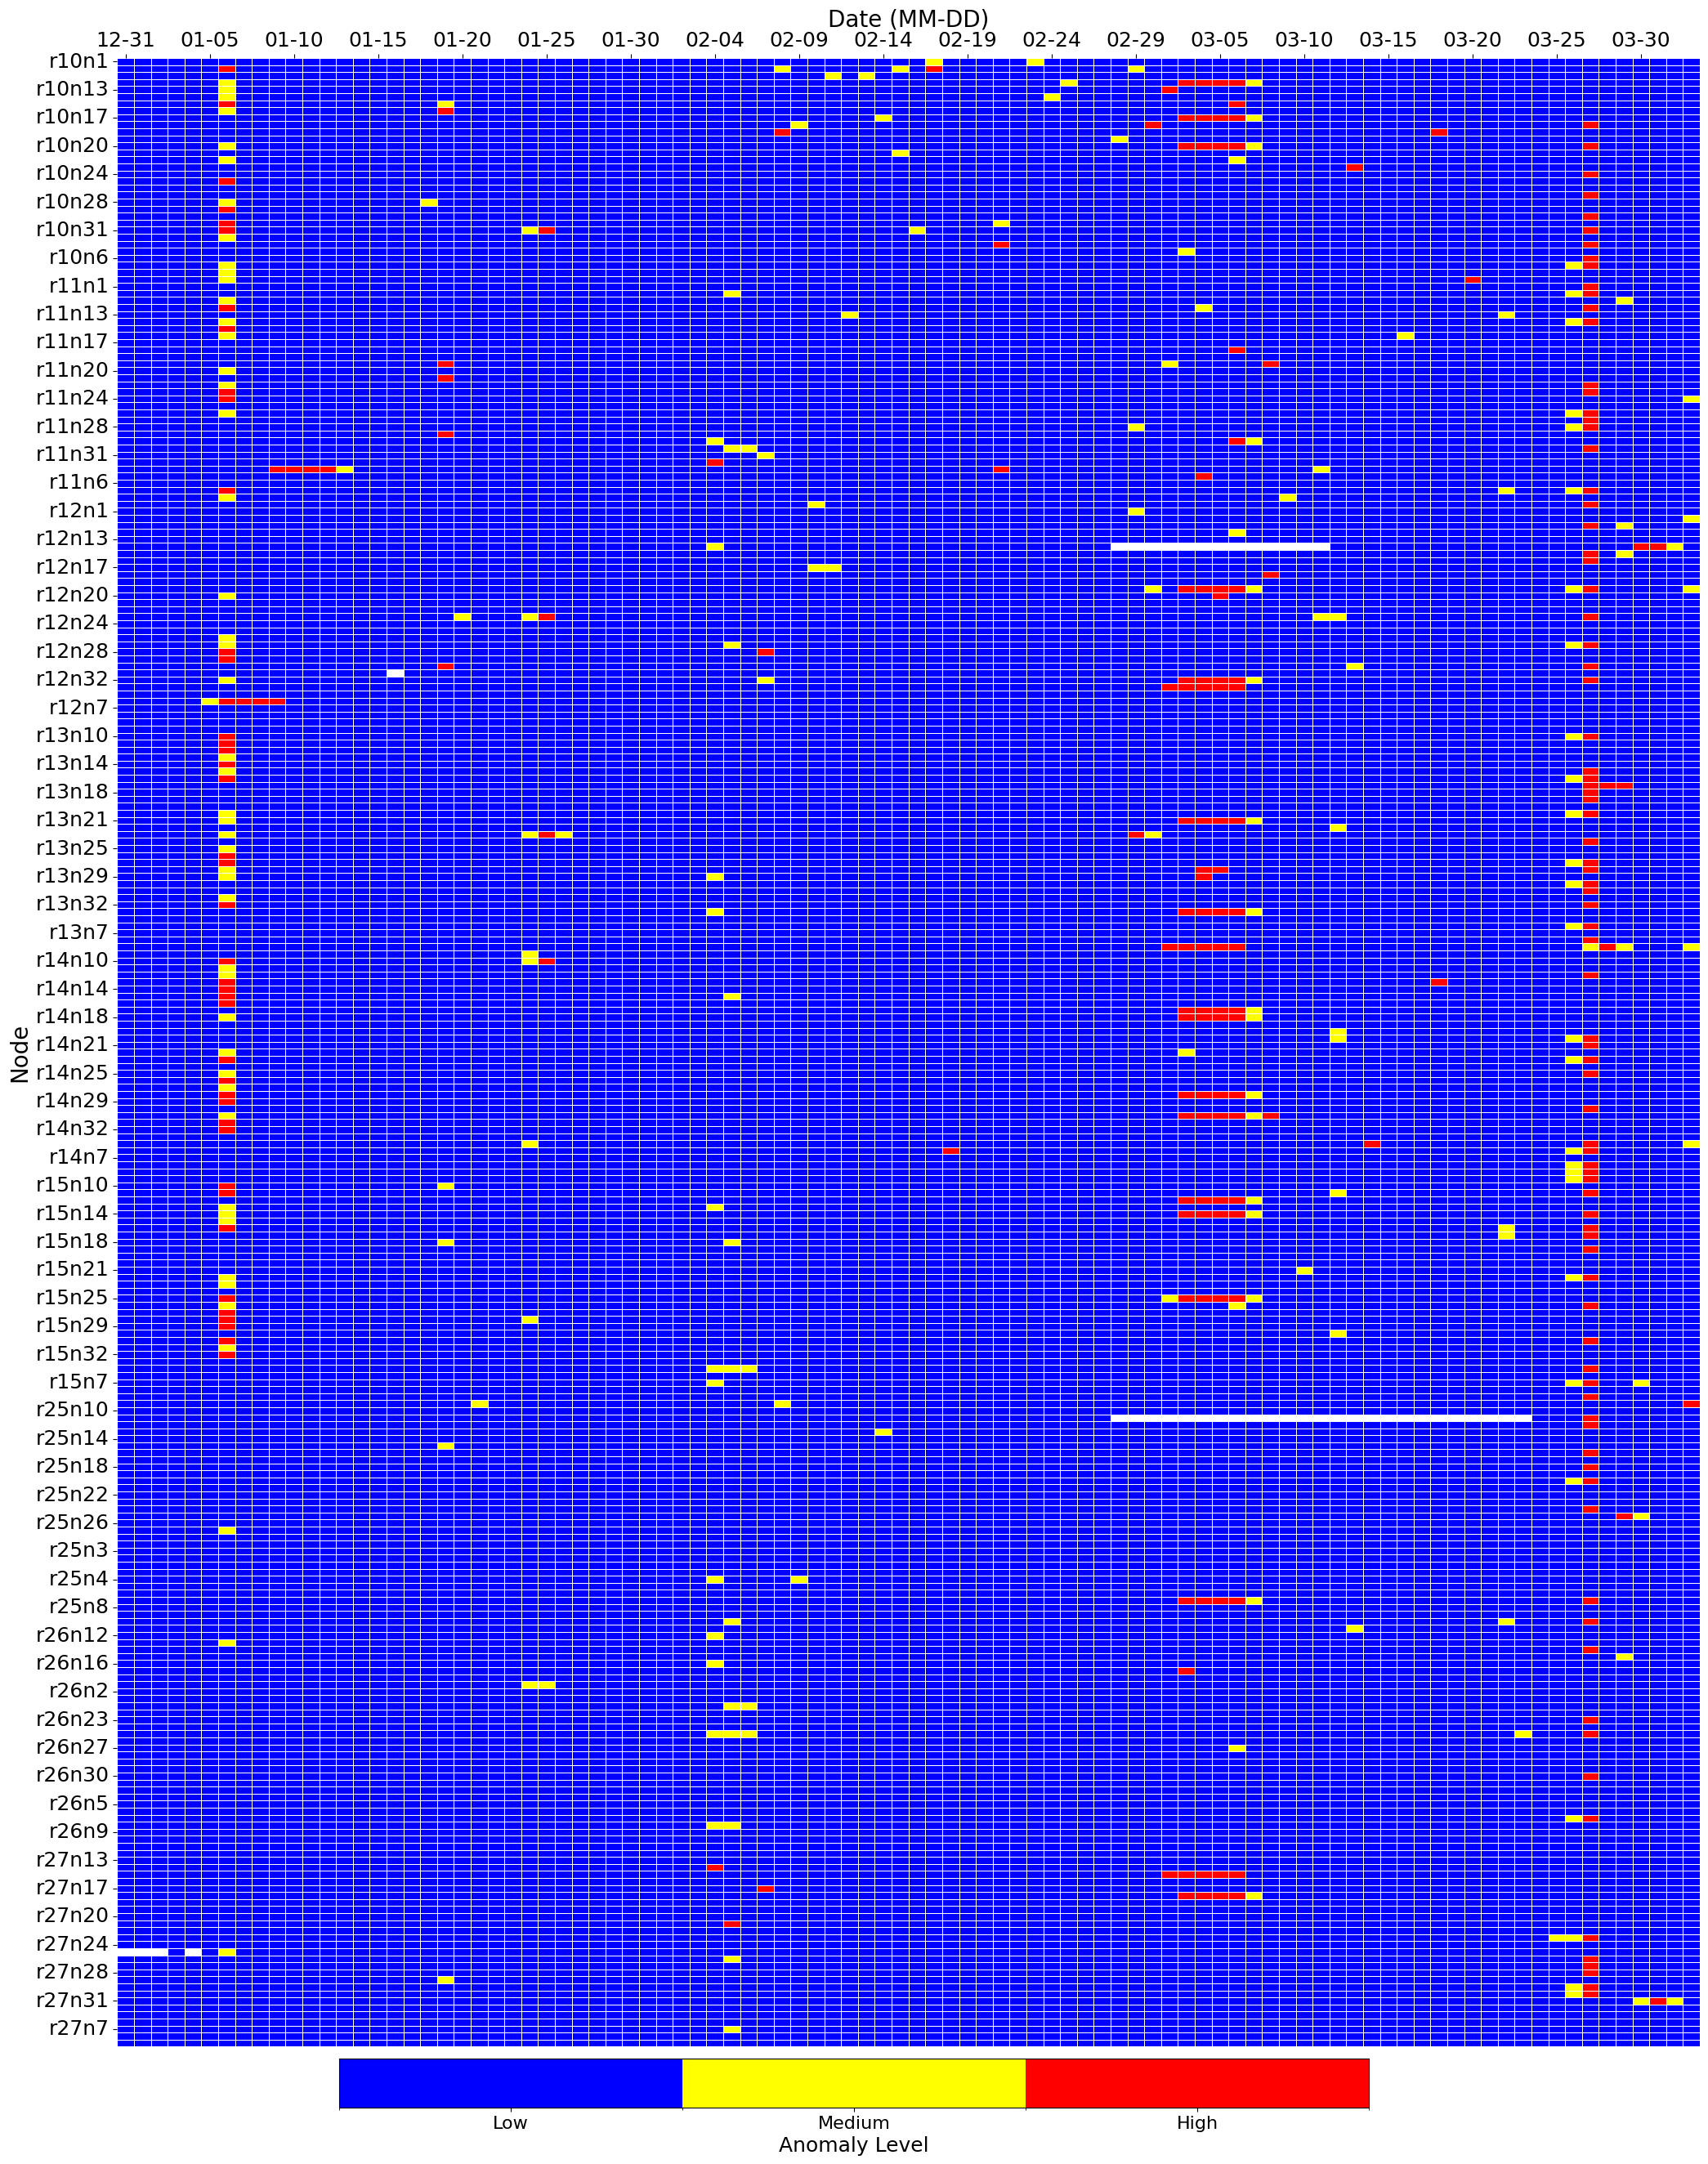

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm


cmap = ListedColormap(['blue', 'yellow', 'red'])
bounds = [0, 0.5, 0.75, 1]
norm = BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(21, 29.7))

sns.heatmap(pivot_df, cmap=cmap, norm=norm, cbar=False, linewidths=.5, ax=ax)

ax.xaxis.tick_top()

n_x, n_y = 5, 2
ax.set_xticks(ax.get_xticks()[::n_x])
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticks(ax.get_yticks()[::n_y])
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

ax.set_xlabel('Date (MM-DD)', fontsize=20)
ax.xaxis.set_label_position('top')  
plt.ylabel('Node', fontsize=20)

cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.02])  
cbar = plt.colorbar(ax.collections[0], cax=cbar_ax, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0.25, 0.625, 0.875], orientation='horizontal')
cbar.set_label('Anomaly Level', fontsize=18)
cbar.ax.set_xticklabels(['Low', 'Medium', 'High'], fontsize=16)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])

plt.savefig('heatmap.pdf', bbox_inches='tight')

plt.show()


In [9]:
dedup_df

,node,node_load15,node_load5,node_load1,node_memory_Active_bytes,node_filesystem_device_error-sum,node_netstat_Icmp_InErrors,node_netstat_Tcp_InErrs,node_netstat_Udp_InErrors,nvidia_gpu_power_usage_milliwatts-max,nvidia_gpu_temperature_celsius-max,isAnomaly
timestamp,,,,,,,,,,,,
2022-06-30 16:00:30,r10n1,15.38,15.39,15.43,1.221620e+10,0.0,2798.0,3.0,0.0,0.0,0.0,0
2022-06-30 16:00:30,r10n10,10.33,10.49,10.60,4.038920e+09,0.0,1.0,0.0,0.0,0.0,0.0,0
2022-06-30 16:00:30,r10n11,6.76,8.41,10.39,3.563060e+10,0.0,6.0,0.0,0.0,0.0,0.0,0
2022-06-30 16:00:30,r10n12,6.75,7.28,6.93,3.298280e+10,0.0,0.0,0.0,0.0,0.0,0.0,0
2022-06-30 16:00:30,r10n13,7.23,6.91,7.40,8.767090e+09,0.0,4.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-22 11:20:30,r37n4,0.00,0.04,0.08,1.041050e+09,0.0,0.0,0.0,0.0,0.0,0.0,0
2022-11-22 11:20:30,r37n6,0.01,0.05,0.10,1.007960e+09,0.0,0.0,0.0,0.0,0.0,0.0,0
2022-11-22 11:20:30,r38n2,0.01,0.04,0.01,1.504280e+09,0.0,0.0,0.0,0.0,34839.0,35.0,0


In [10]:
import pandas as pd
import matplotlib.colors as mcolors
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

dedup_df.index = pd.to_datetime(dedup_df.index)

data_density = dedup_df.groupby([dedup_df['node'], dedup_df.index.date])['isAnomaly'].count().unstack(fill_value=0)

anomaly_density = dedup_df.groupby([dedup_df['node'], dedup_df.index.date])['isAnomaly'].sum().unstack(fill_value=0)

max_data = data_density.max().max()
max_anomalies = anomaly_density.max().max()

data_density_normalized = data_density / max_data
anomaly_density_normalized = anomaly_density / max_anomalies

data_density_normalized.index = pd.to_datetime(data_density_normalized.index).strftime('%m-%d')
anomaly_density_normalized.index = pd.to_datetime(anomaly_density_normalized.index).strftime('%m-%d')


heatmap_values = data_density_normalized - anomaly_density_normalized * data_density_normalized

cmap = mcolors.LinearSegmentedColormap.from_list("n", ['
plt.figure(figsize=(21, 29.7))

cbar_kws = {'orientation': 'horizontal', 'fraction': 0.01, 'pad': 0.05}

sns.heatmap(heatmap_values, cmap=cmap, cbar_kws=cbar_kws, linewidths=.5)

plt.xlabel('Node')
plt.ylabel('Date (MM-DD)')

plt.savefig('heatmap.pdf', bbox_inches='tight')

plt.show()


AttributeError: 'Index' object has no attribute 'strftime'

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


dedup_df.index = pd.to_datetime(dedup_df.index)

data_density = dedup_df.groupby([dedup_df.index.date, 'node'])['total_anomaly'].count().unstack(fill_value=0)
max_data_points = data_density.max().max()  
data_density_normalized = data_density / max_data_points

anomaly_density = dedup_df.groupby([dedup_df.index.date, 'node'])['isAnomaly'].sum().unstack(fill_value=0)
max_anomalies = anomaly_density.max().max()  
anomaly_density_normalized = anomaly_density / max_anomalies

overall_values = data_density_normalized + anomaly_density_normalized.multiply(data_density_normalized)

new_columns = [str(i.date().strftime('%m-%d')) for i in data_density_normalized.columns]
overall_values.columns = new_columns

cmap = sns.diverging_palette(250, 10, as_cmap=True)

plt.figure(figsize=(21, 29.7))
sns.heatmap(overall_values, cmap=cmap, cbar_kws={'label': 'Data Completeness + Anomaly Density'}, linewidths=.5)

plt.xlabel('Date (MM-DD)')
plt.ylabel('Node')

plt.savefig('heatmap.pdf', bbox_inches='tight')
plt.show()


KeyError: 'Column not found: total_anomaly'

In [12]:
data_density = dedup_df.groupby([dedup_df.index.date, 'node']).count().unstack(fill_value=0)['isAnomaly']
max_data_points = data_density.max().max()  
data_density_normalized = data_density / max_data_points

anomaly_density = dedup_df.groupby([dedup_df.index.date, 'node'])['isAnomaly'].sum().unstack(fill_value=0)
max_anomalies = anomaly_density.max().max()  
anomaly_density_normalized = anomaly_density / max_anomalies


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


dedup_df.index = pd.to_datetime(dedup_df.index)

data_density = dedup_df.groupby([dedup_df.index.date, 'node'])['total_anomaly'].count().unstack(fill_value=0)
max_data_points = data_density.max().max()  
data_density_normalized = data_density / max_data_points

anomaly_density = dedup_df.groupby([dedup_df.index.date, 'node'])['isAnomaly'].sum().unstack(fill_value=0)
max_anomalies = anomaly_density.max().max()  
anomaly_density_normalized = anomaly_density / max_anomalies

overall_values = data_density_normalized + anomaly_density_normalized.multiply(data_density_normalized)

new_columns = [str(i.date().strftime('%m-%d')) for i in data_density_normalized.columns]
overall_values.columns = new_columns

colors = ["deepskyblue", "lightskyblue", "white", "lightsalmon", "darkred"]
cmap = sns.color_palette(colors)

vmin_val = np.min(overall_values.values)
vmax_val = np.max(overall_values.values)
center_val = 0  

plt.figure(figsize=(21, 29.7))
sns.heatmap(overall_values, cmap=cmap, center=center_val, cbar_kws={'label': 'Data Completeness + Anomaly Density'}, linewidths=.5, vmin=vmin_val, vmax=vmax_val)

plt.xlabel('Date (MM-DD)')
plt.ylabel('Node')

plt.savefig('heatmap_custom_adjusted.pdf', bbox_inches='tight')
plt.show()


KeyboardInterrupt: 

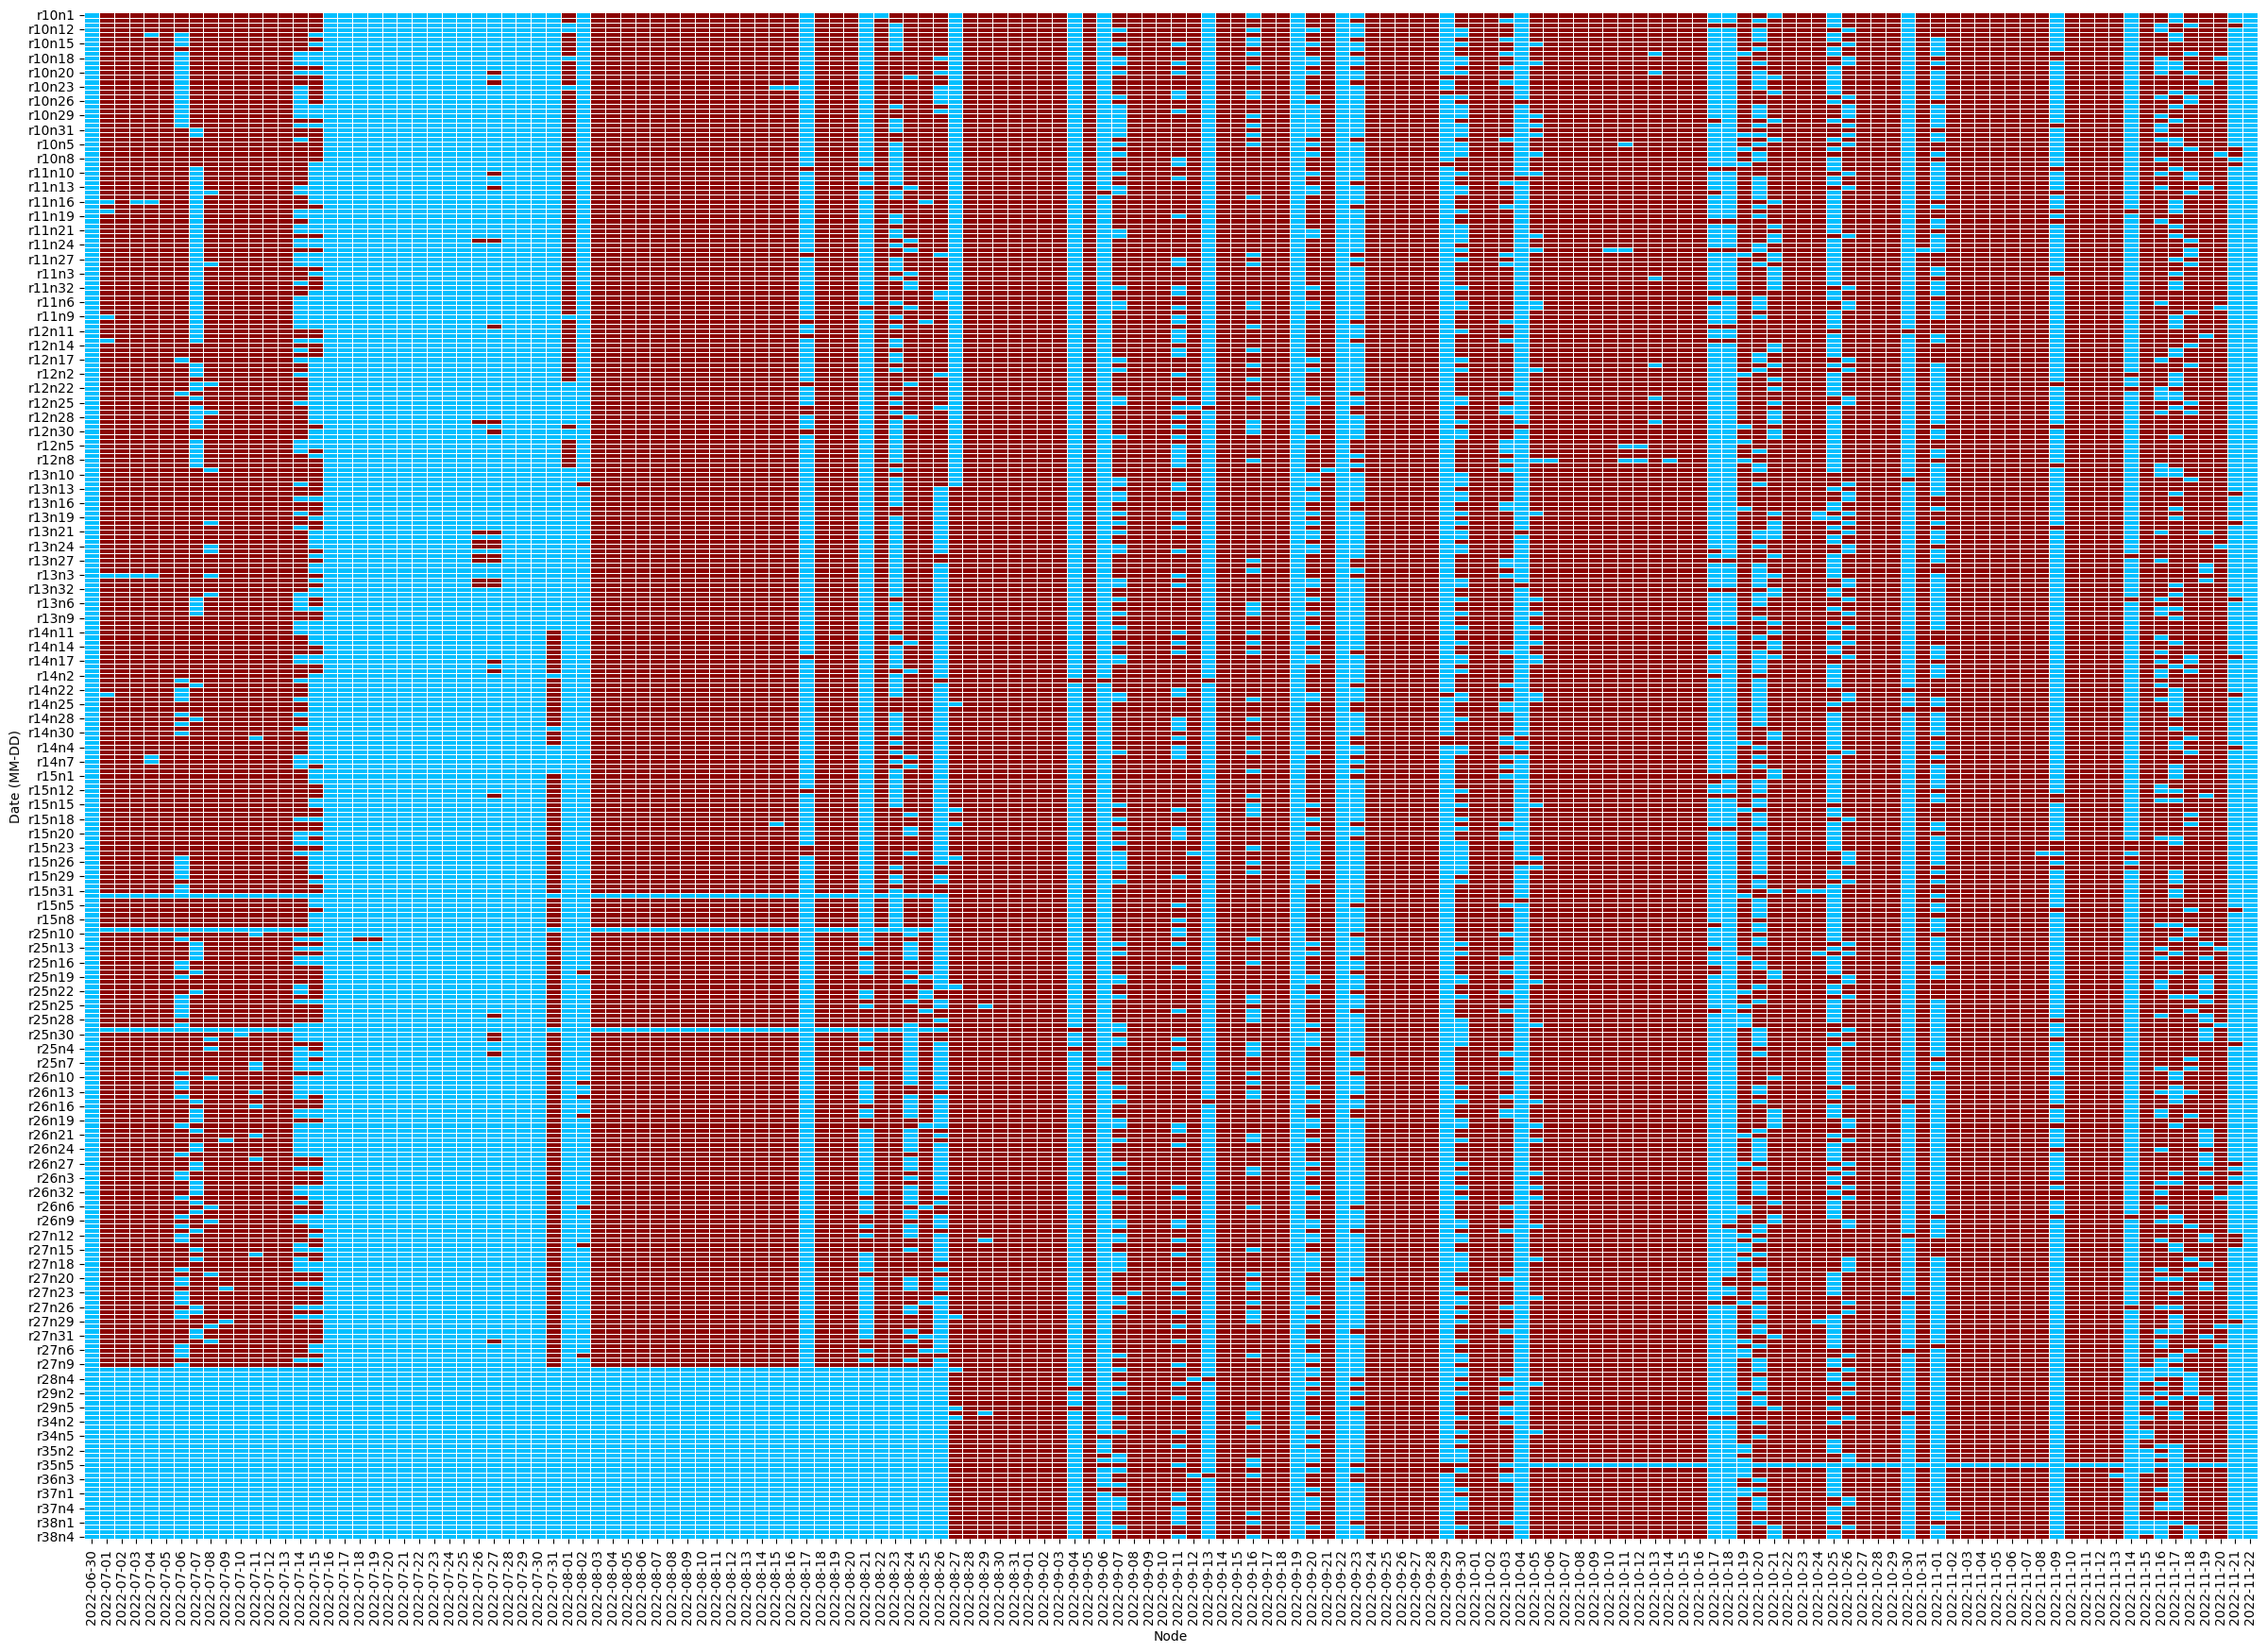

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns







colors = ["deepskyblue", "darkred"]
cmap = sns.color_palette(colors)

vmin_val = np.min(overall_values.values)
vmax_val = np.max(overall_values.values)

plt.figure(figsize=(29.7, 21))

transposed_values = overall_values.transpose()

sns.heatmap(transposed_values, cmap=cmap, cbar=False, linewidths=.5, vmin=vmin_val, vmax=vmax_val)

plt.ylabel('Date (MM-DD)')
plt.xlabel('Node')

plt.savefig('heatmap_custom_horizontal.pdf', bbox_inches='tight')
plt.show()


In [5]:
import matplotlib.colors as mcolors
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

resampled_df = dedup_df.groupby('node').resample('D').mean().reset_index()

pivot_df = resampled_df.pivot(index='timestamp', columns='node', values='isAnomaly')

pivot_df.index = pivot_df.index.strftime('%m-%d')

anomaly_df = pivot_df.copy()
anomaly_df[anomaly_df < 1] = np.nan

cmap = mcolors.LinearSegmentedColormap.from_list("n",['

plt.figure(figsize=(21, 29.7))

cbar_kws = {'orientation': 'horizontal', 'fraction': 0.01, 'pad': 0.05}

sns.heatmap(pivot_df, cmap=cmap, cbar=False, linewidths=.5)

sns.heatmap(anomaly_df, cmap=['None', 'red'], cbar=False, linewidths=.5)

plt.xlabel('Node')
plt.ylabel('Date (MM-DD)')

plt.savefig('heatmap.pdf', bbox_inches='tight')

plt.show()


NameError: name 'dedup_df' is not defined

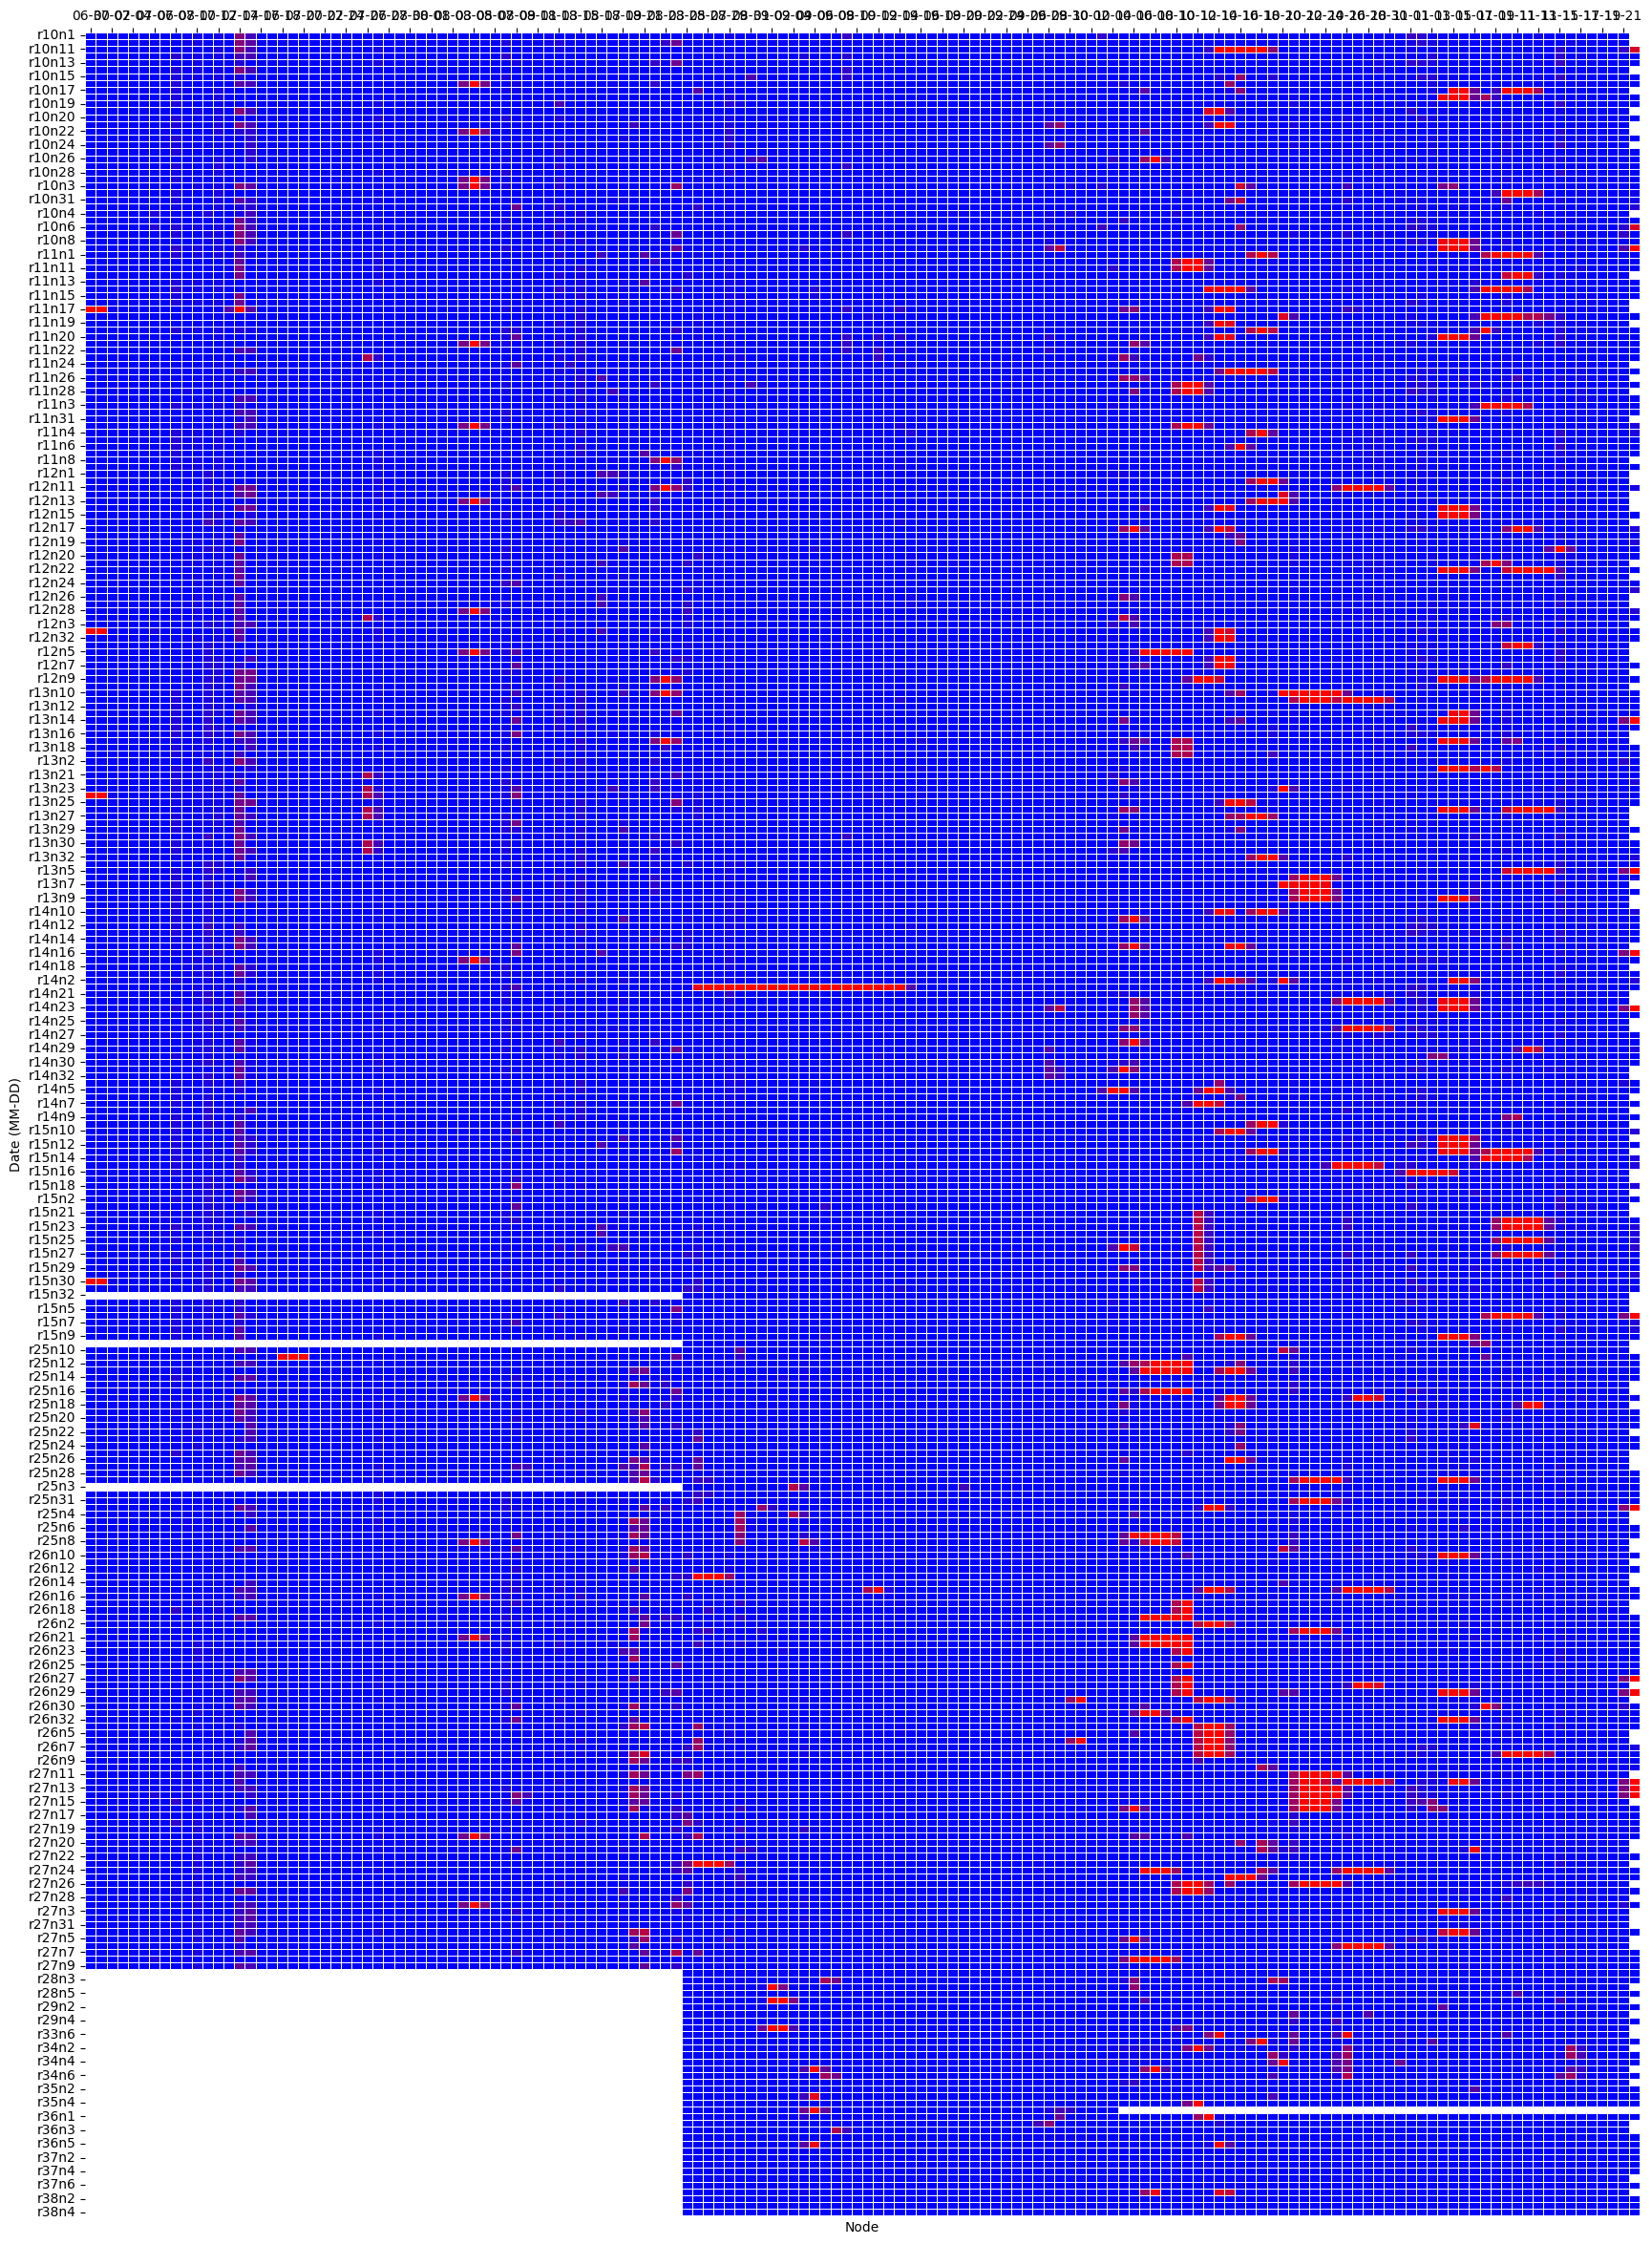

In [21]:

plt.figure(figsize=(21, 29.7))

cbar_kws = {'orientation': 'horizontal', 'fraction': 0.01, 'pad': 0.05}

ax = sns.heatmap(pivot_df, cmap=cmap, cbar=False, linewidths=.5)

sns.heatmap(anomaly_df, cmap=['None', 'red'], cbar=False, linewidths=.5)

ax.xaxis.tick_top()

plt.xlabel('Node')
plt.ylabel('Date (MM-DD)')

plt.savefig('heatmap.pdf', bbox_inches='tight')

plt.show()


In [8]:
dedup_df['timestamp'] = pd.to_datetime(dedup_df['timestamp'], unit='s')

dedup_df.set_index('timestamp', inplace=True)

resampled_df = dedup_df.groupby('node').resample('D').mean().reset_index()


KeyError: 'timestamp'

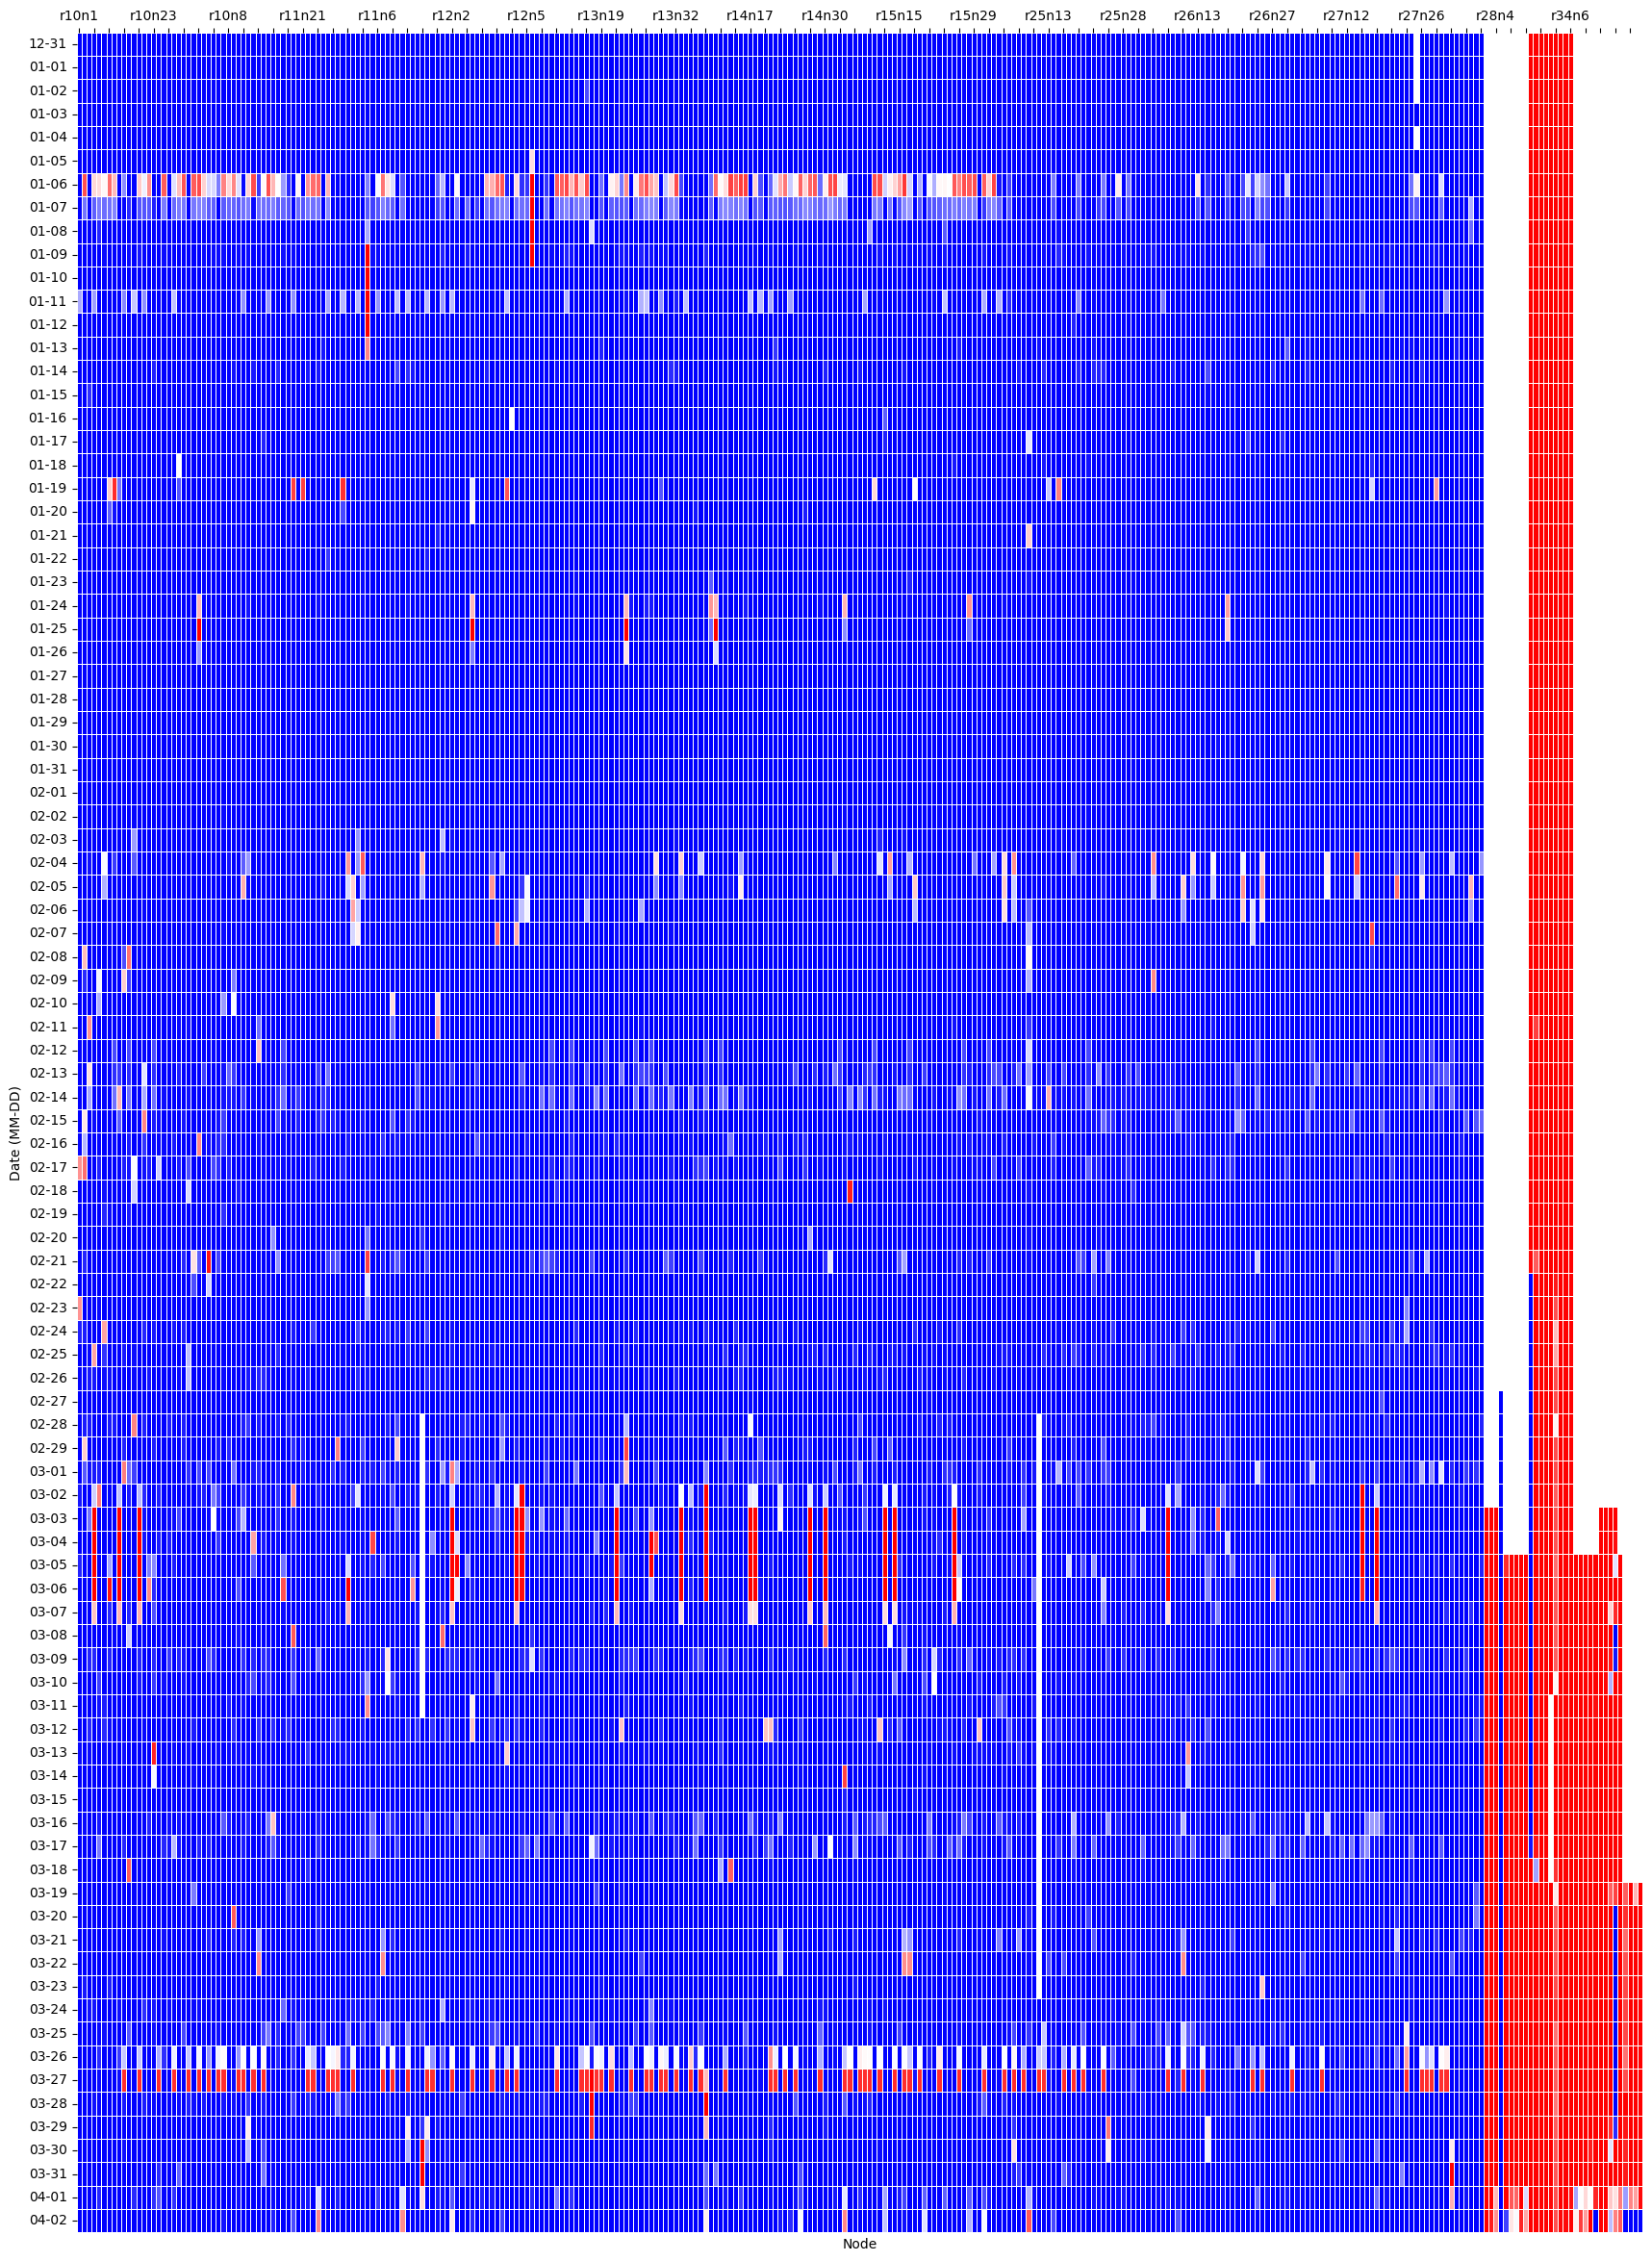

In [11]:
import matplotlib.colors as mcolors
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


pivot_df = resampled_df.pivot(index='timestamp', columns='node', values='isAnomaly')

pivot_df.index = pivot_df.index.strftime('%m-%d')

anomaly_df = pivot_df.copy()
anomaly_df[anomaly_df < 1] = np.nan

cmap = mcolors.LinearSegmentedColormap.from_list("n",['

plt.figure(figsize=(21, 29.7))

cbar_kws = {'orientation': 'horizontal', 'fraction': 0.01, 'pad': 0.05}

ax = sns.heatmap(pivot_df, cmap=cmap, cbar=False, linewidths=.5)

sns.heatmap(anomaly_df, cmap=['None', 'red'], cbar=False, linewidths=.5, ax=ax)

ax.xaxis.tick_top()

n = 5
labels = [label.get_text() for label in ax.get_xticklabels()]
sparse_labels = ['' if (i % n) != 0 else label for i, label in enumerate(labels)]
ax.set_xticklabels(sparse_labels)

plt.xlabel('Node', position=(1,0))
plt.ylabel('Date (MM-DD)')

plt.savefig('heatmap.pdf', bbox_inches='tight')

plt.show()


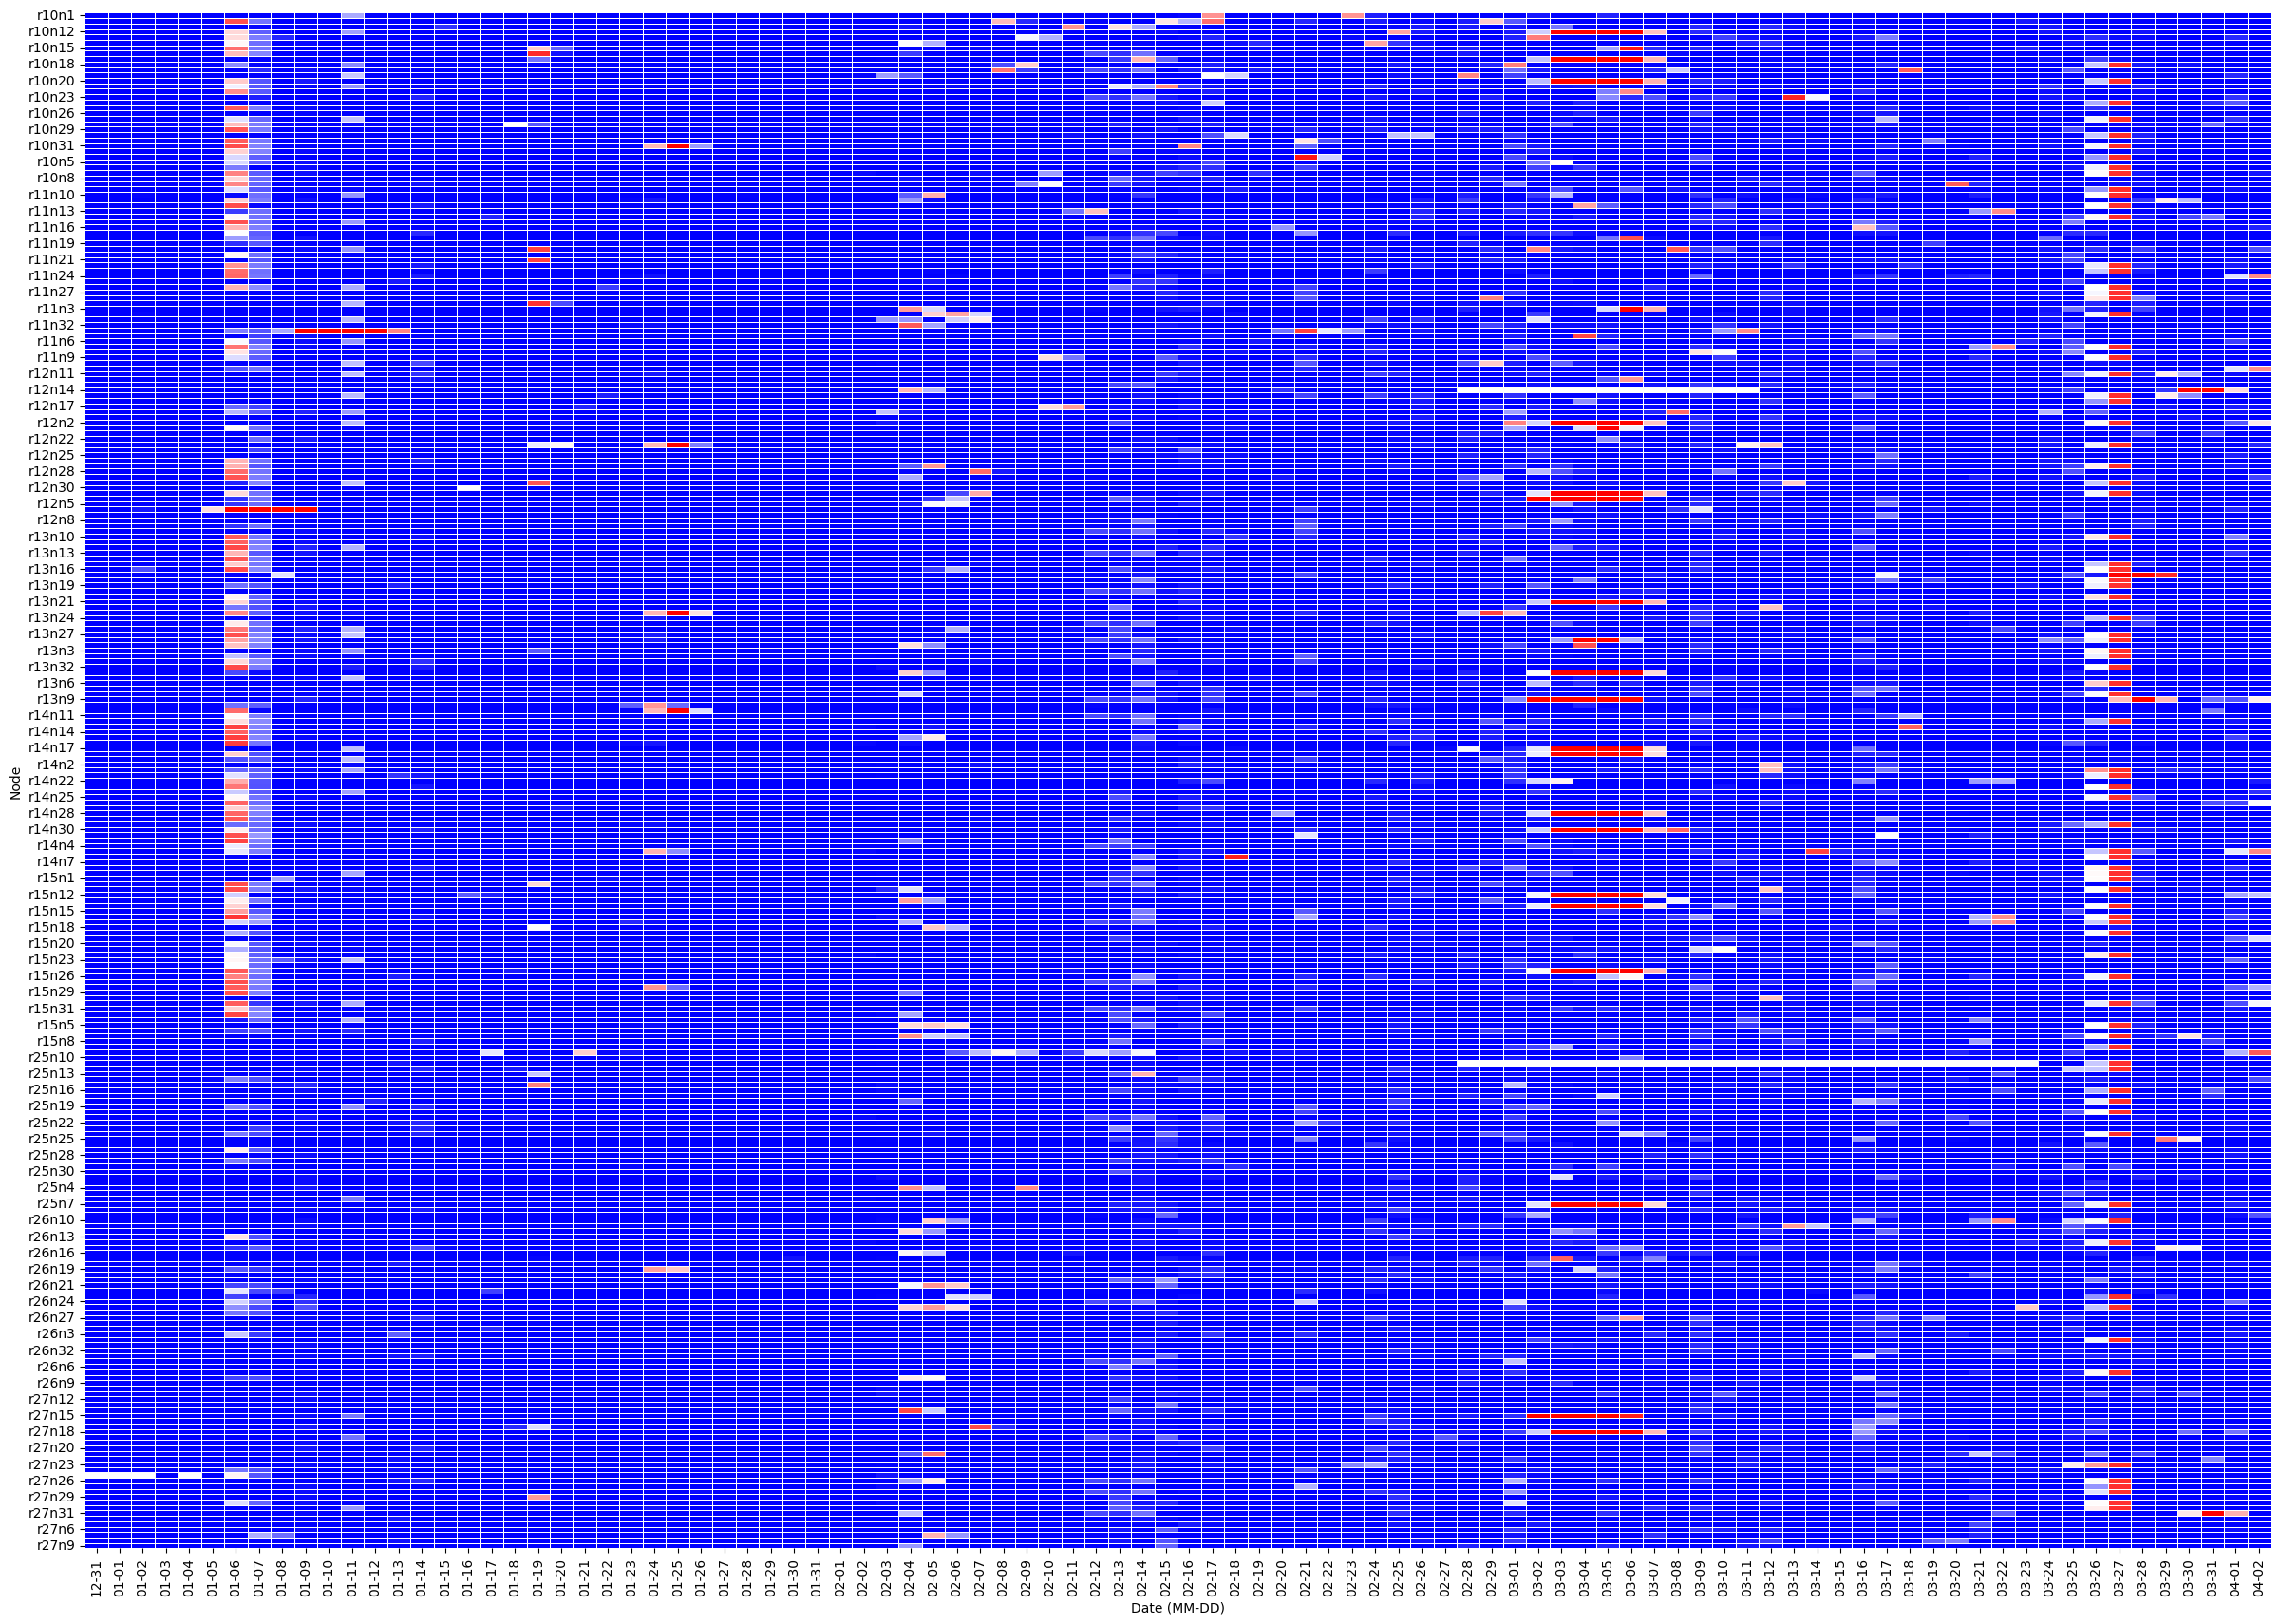

In [16]:

pivot_df = resampled_df.pivot(columns='timestamp', index='node', values='isAnomaly')

pivot_df.columns = pivot_df.columns.strftime('%m-%d')

anomaly_df = pivot_df.copy()
anomaly_df[anomaly_df < 1] = np.nan

cmap = mcolors.LinearSegmentedColormap.from_list("n",['

plt.figure(figsize=(29.7, 21))  

cbar_kws = {'orientation': 'vertical', 'fraction': 0.01, 'pad': 0.05}

sns.heatmap(pivot_df, cmap=cmap, cbar=False, linewidths=.5)

sns.heatmap(anomaly_df, cmap=['None', 'red'], cbar=False, linewidths=.5)

plt.ylabel('Node')
plt.xlabel('Date (MM-DD)')

plt.savefig('heatmap_horizontal.pdf', bbox_inches='tight')

plt.show()


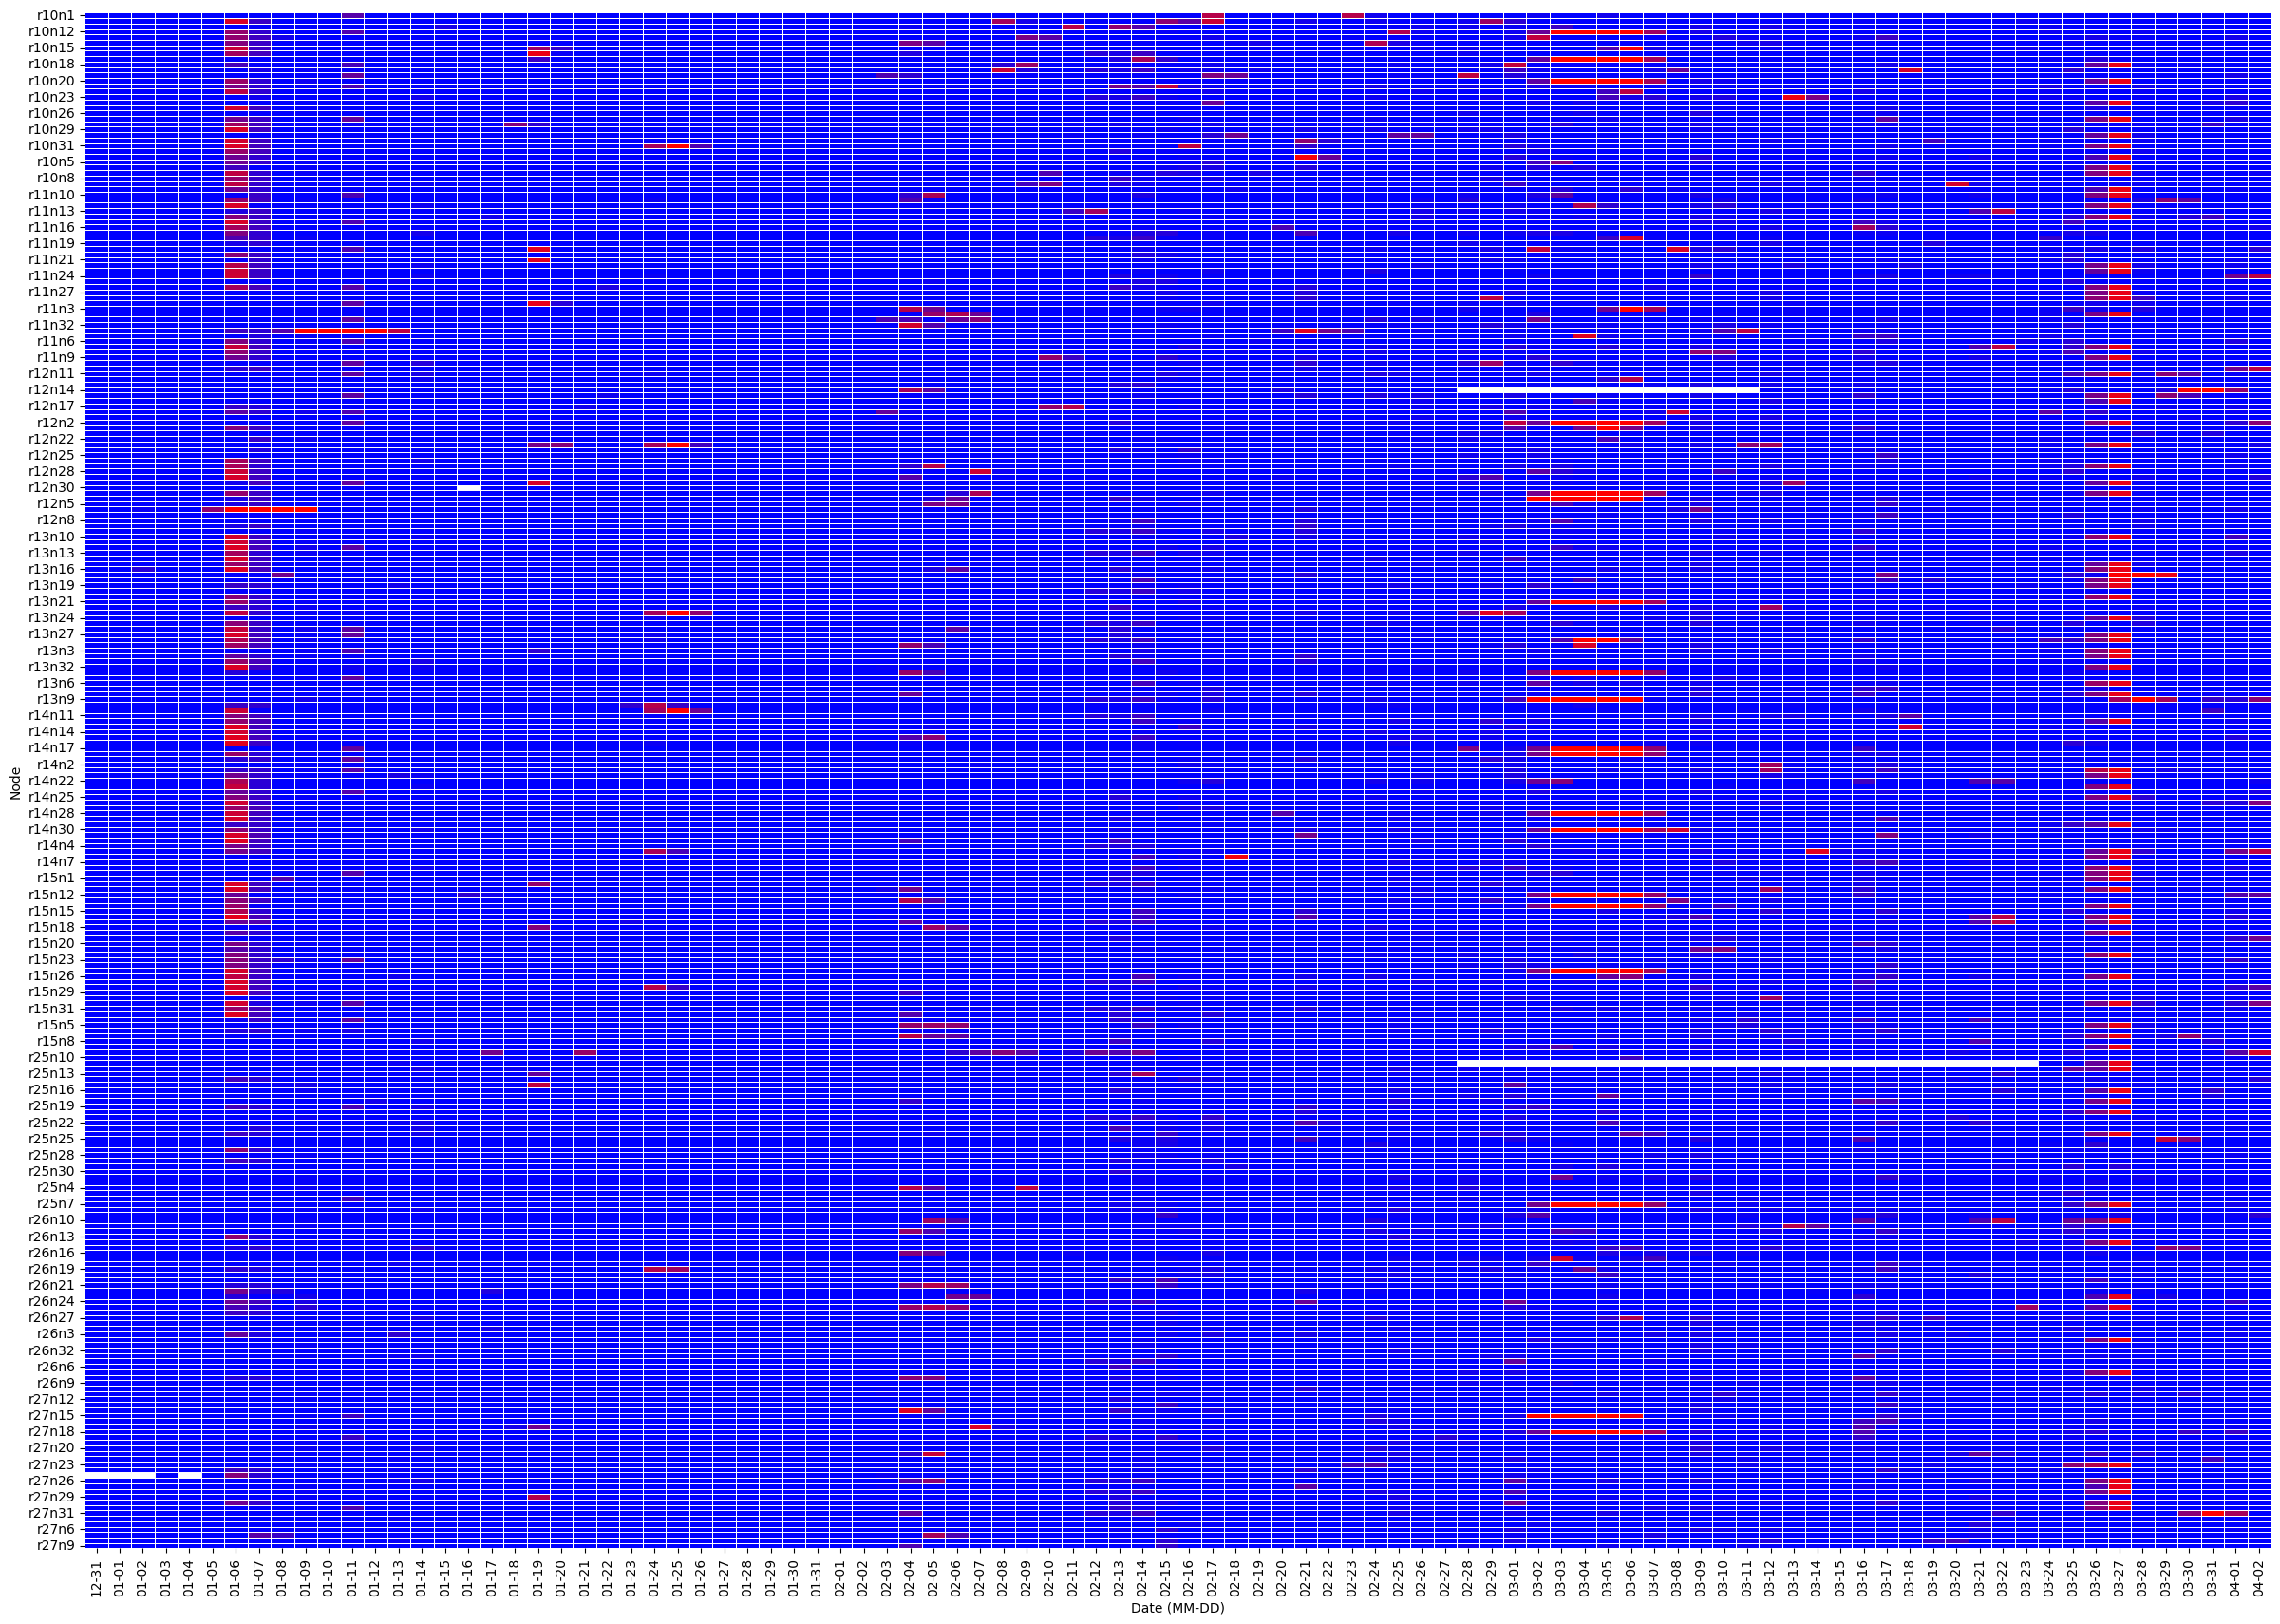

In [17]:

pivot_df = resampled_df.pivot(columns='timestamp', index='node', values='isAnomaly')

pivot_df.columns = pivot_df.columns.strftime('%m-%d')

anomaly_df = pivot_df.copy()
anomaly_df[anomaly_df < 1] = np.nan

cmap = mcolors.LinearSegmentedColormap.from_list("n",['

plt.figure(figsize=(29.7, 21))  
sns.heatmap(pivot_df, cmap=cmap, cbar=False, linewidths=.5)

plt.ylabel('Node')
plt.xlabel('Date (MM-DD)')

plt.savefig('heatmap_horizontal.pdf', bbox_inches='tight')

plt.show()


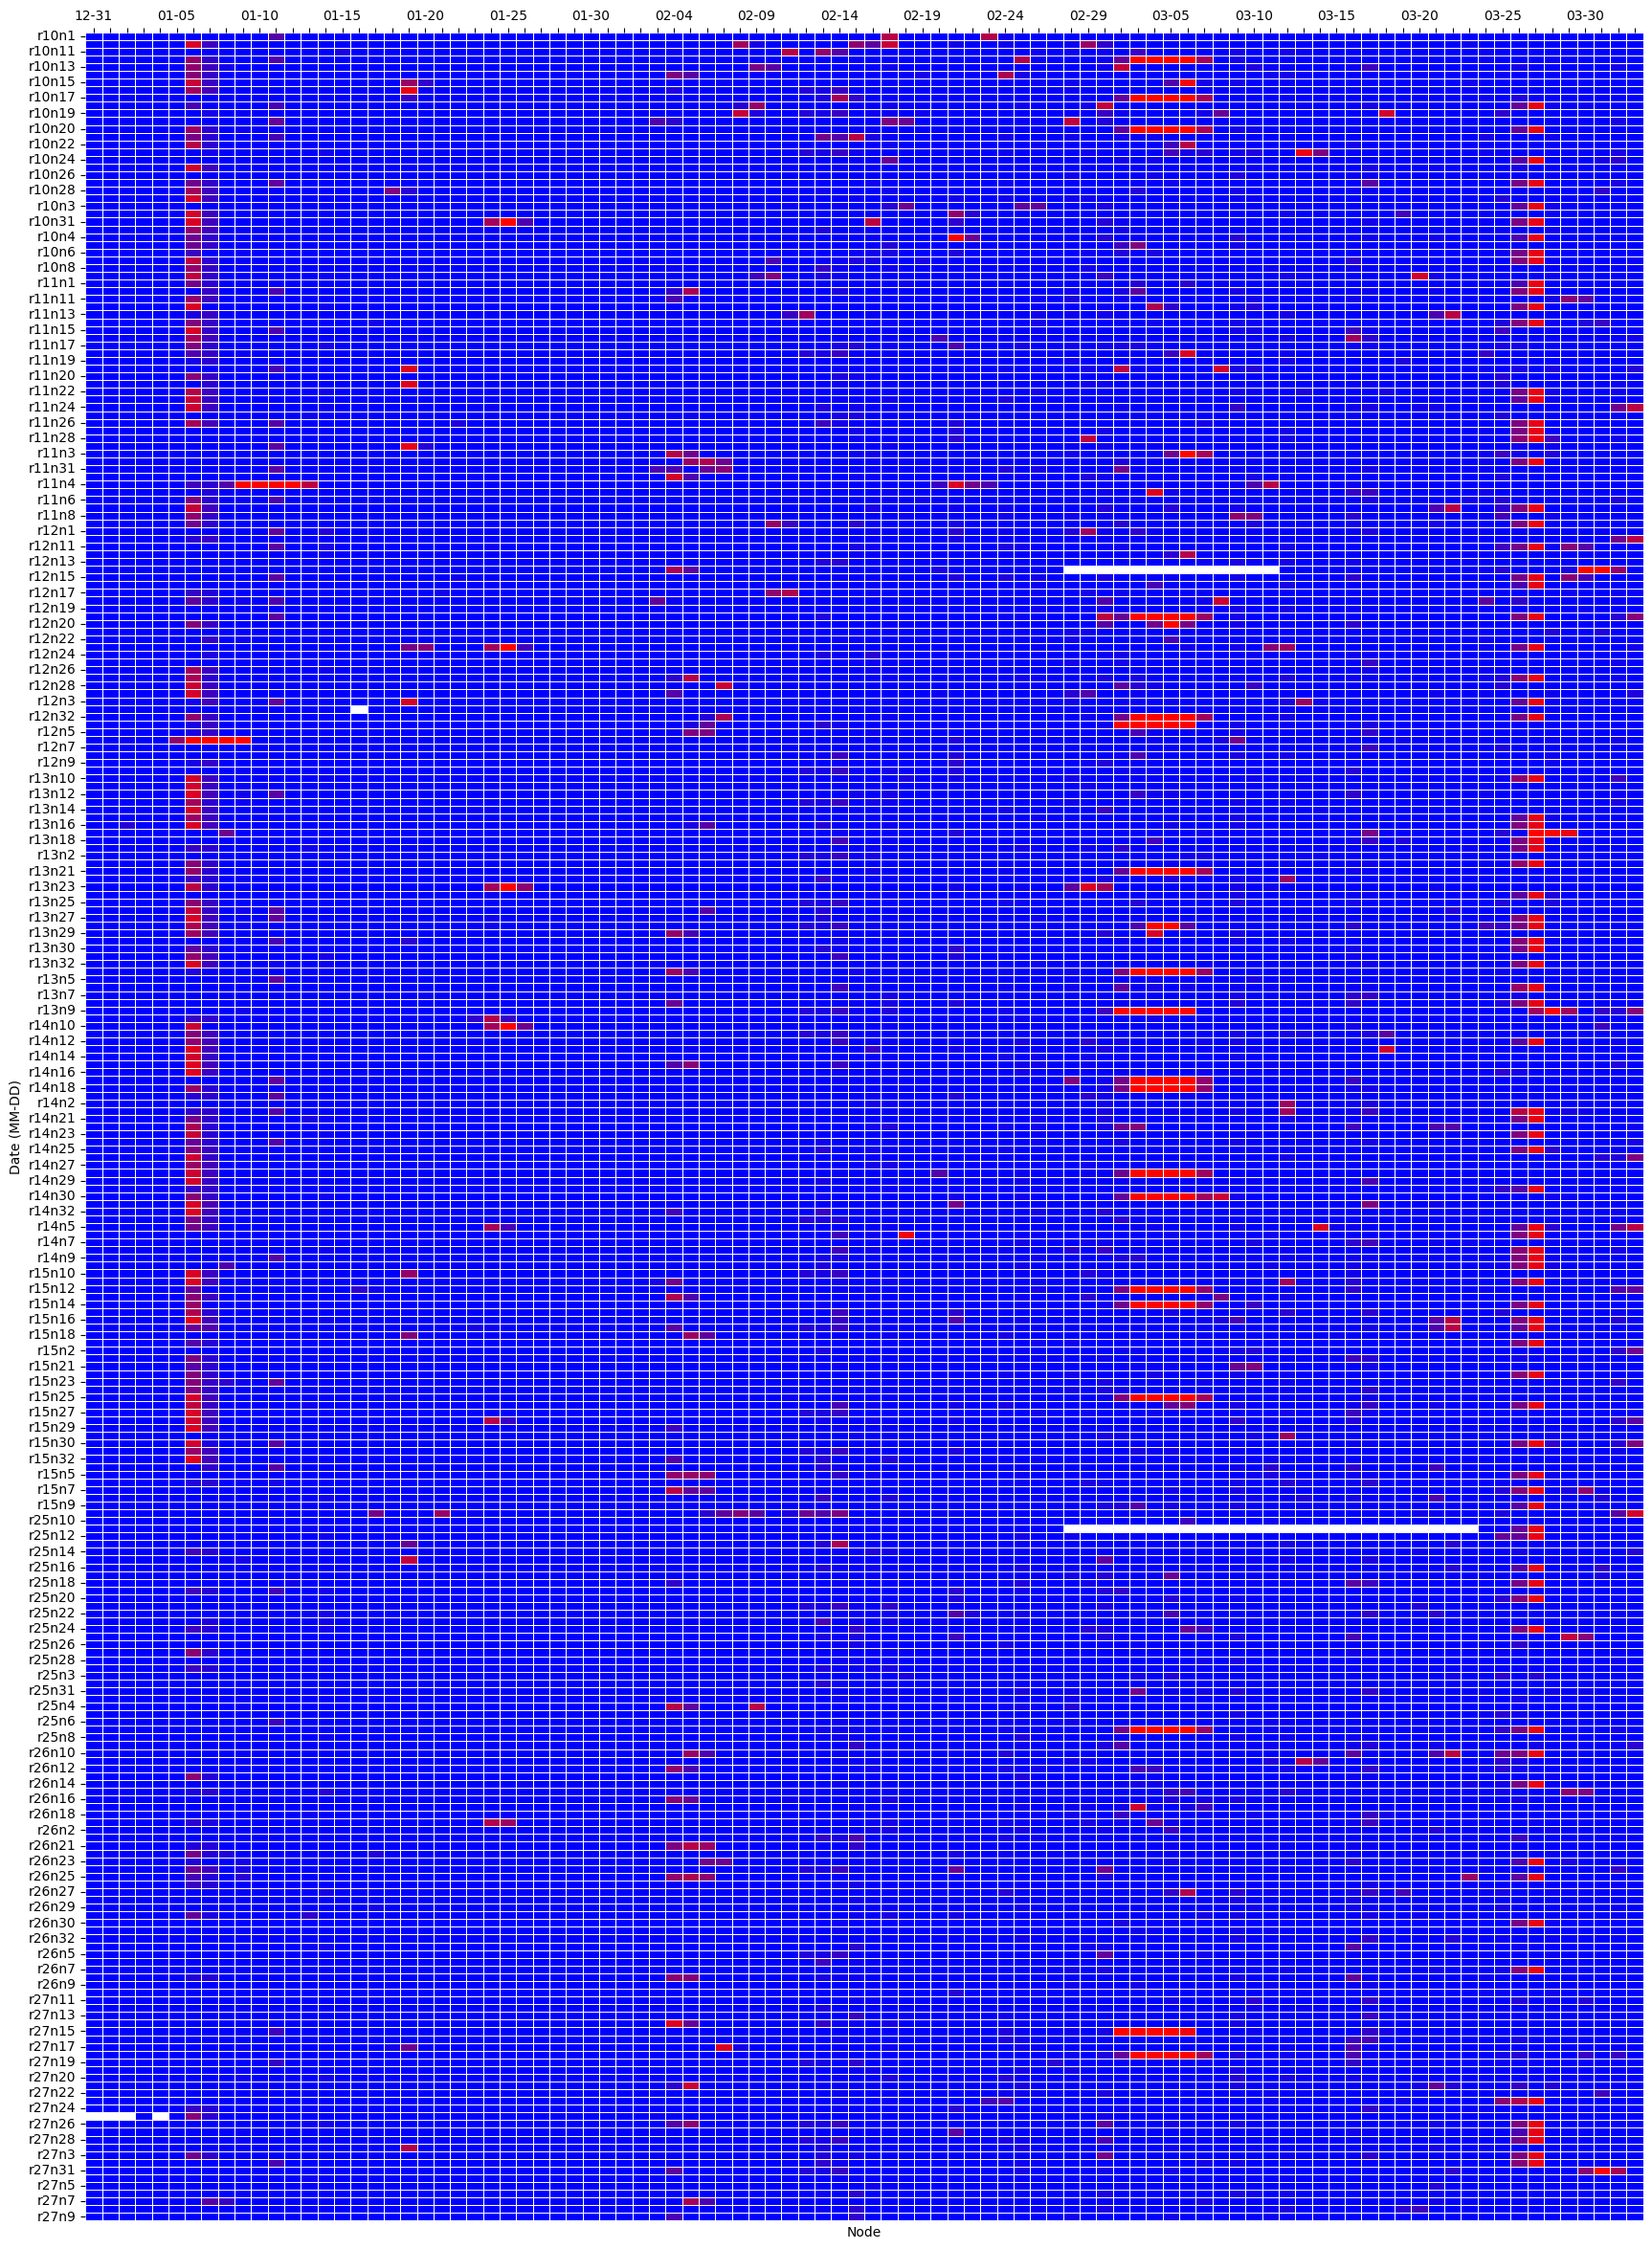

In [18]:

plt.figure(figsize=(21, 29.7))

cbar_kws = {'orientation': 'horizontal', 'fraction': 0.01, 'pad': 0.05}

ax = sns.heatmap(pivot_df, cmap=cmap, cbar=False, linewidths=.5)

sns.heatmap(anomaly_df, cmap=['None', 'red'], cbar=False, linewidths=.5, ax=ax)

ax.xaxis.tick_top()

n = 5
labels = [label.get_text() for label in ax.get_xticklabels()]
sparse_labels = ['' if (i % n) != 0 else label for i, label in enumerate(labels)]
ax.set_xticklabels(sparse_labels)

plt.xlabel('Node', position=(1,0))
plt.ylabel('Date (MM-DD)')

plt.savefig('heatmap.pdf', bbox_inches='tight')

plt.show()


In [15]:


colors = ['

q25 = pivot_df[pivot_df < 1].quantile(0.25).min()
q75 = pivot_df[pivot_df < 1].quantile(0.75).max()

boundaries = [pivot_df.min().min(), q25, q75, 1, pivot_df.max().max()]
norm = mcolors.BoundaryNorm(boundaries, len(colors))
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

plt.figure(figsize=(29.7, 21))  

sns.heatmap(pivot_df, cmap=cmap, norm=norm, cbar=False, linewidths=.5)

plt.ylabel('Node')
plt.xlabel('Date (MM-DD)')

plt.savefig('heatmap_horizontal.pdf', bbox_inches='tight')

plt.show()


ValueError: There are 4 color bins including extensions, but ncolors = 3; ncolors must equal or exceed the number of bins

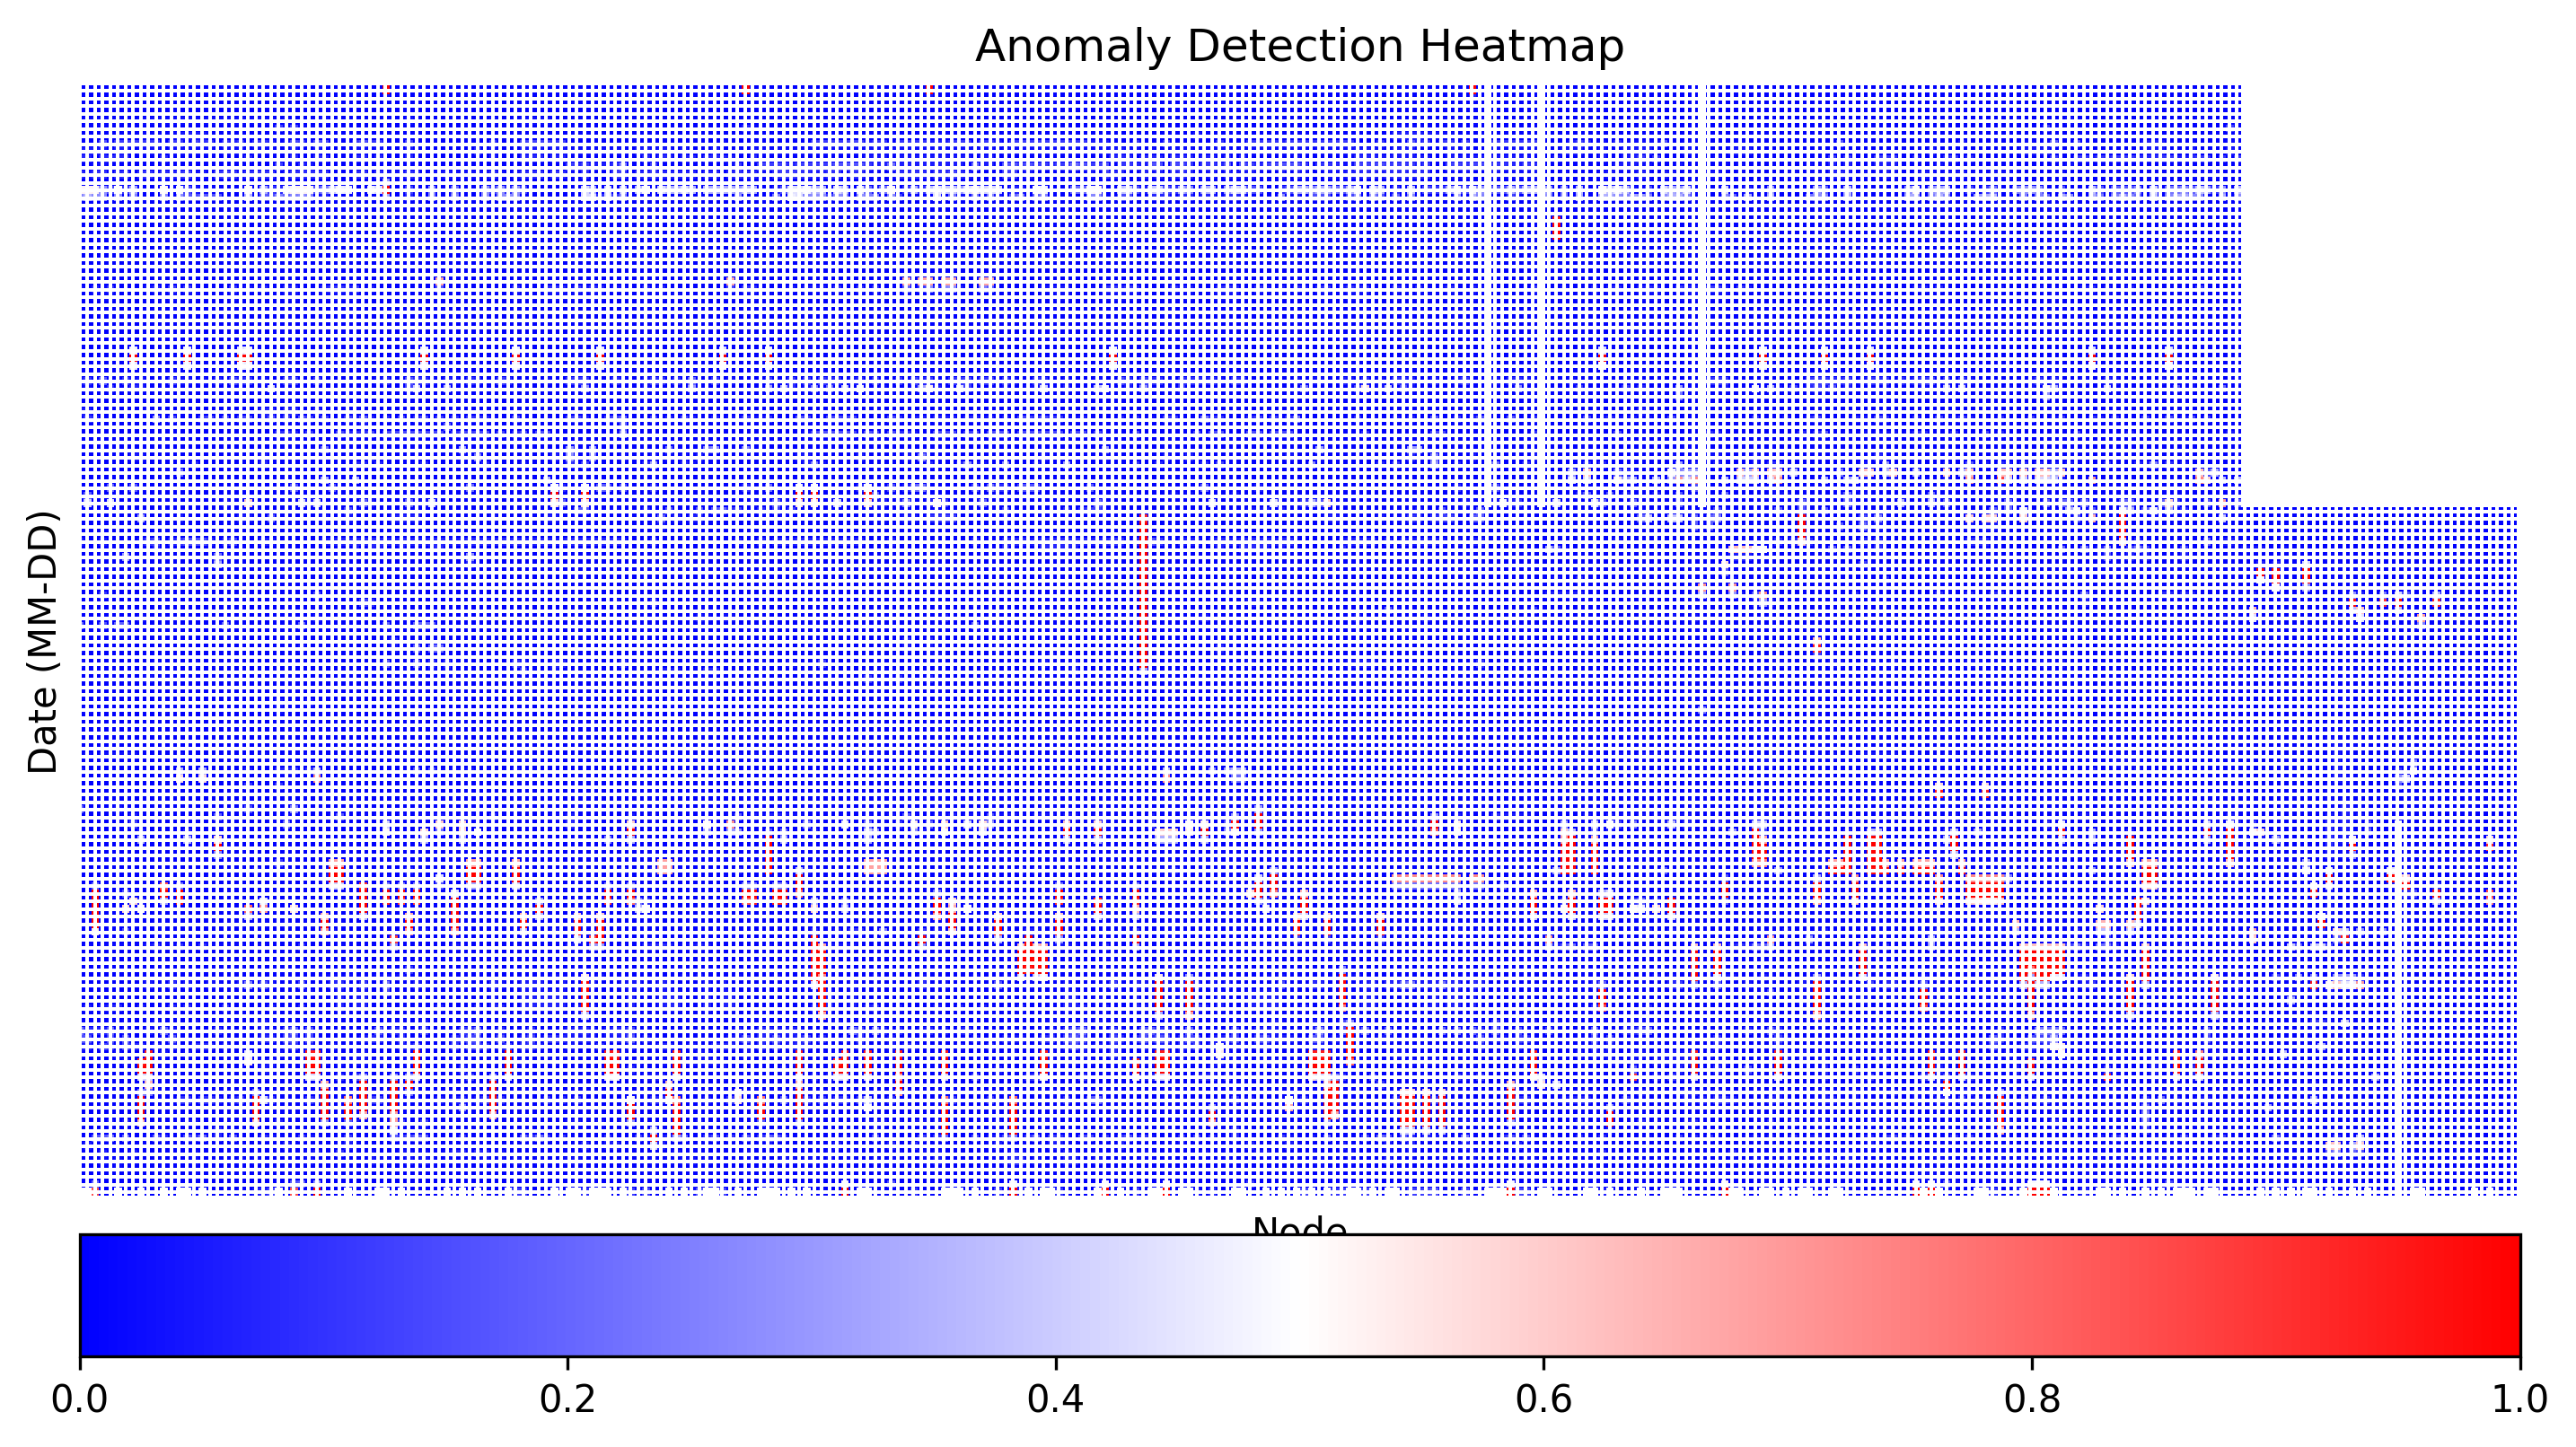

In [11]:
fig, ax = plt.subplots(figsize=(11.69, 8.27), dpi=300)
cax = ax.matshow(pivot_df, cmap=cmap)

sns.heatmap(anomaly_df, cmap=['None', 'red'], cbar=False, linewidths=.5)

ax.set_title('Anomaly Detection Heatmap')
ax.set_xlabel('Node')
ax.set_ylabel('Date (MM-DD)')

for edge, spine in ax.spines.items():
    spine.set_visible(False)

ax.set_xticks([])
ax.set_yticks([])

cbar = fig.colorbar(cax, orientation='horizontal', pad=0.02)
cbar.ax.xaxis.set_major_locator(ticker.AutoLocator())

plt.savefig('heatmap.pdf', bbox_inches='tight')

plt.show()

In [14]:
plt.savefig('heatmap.pdf', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

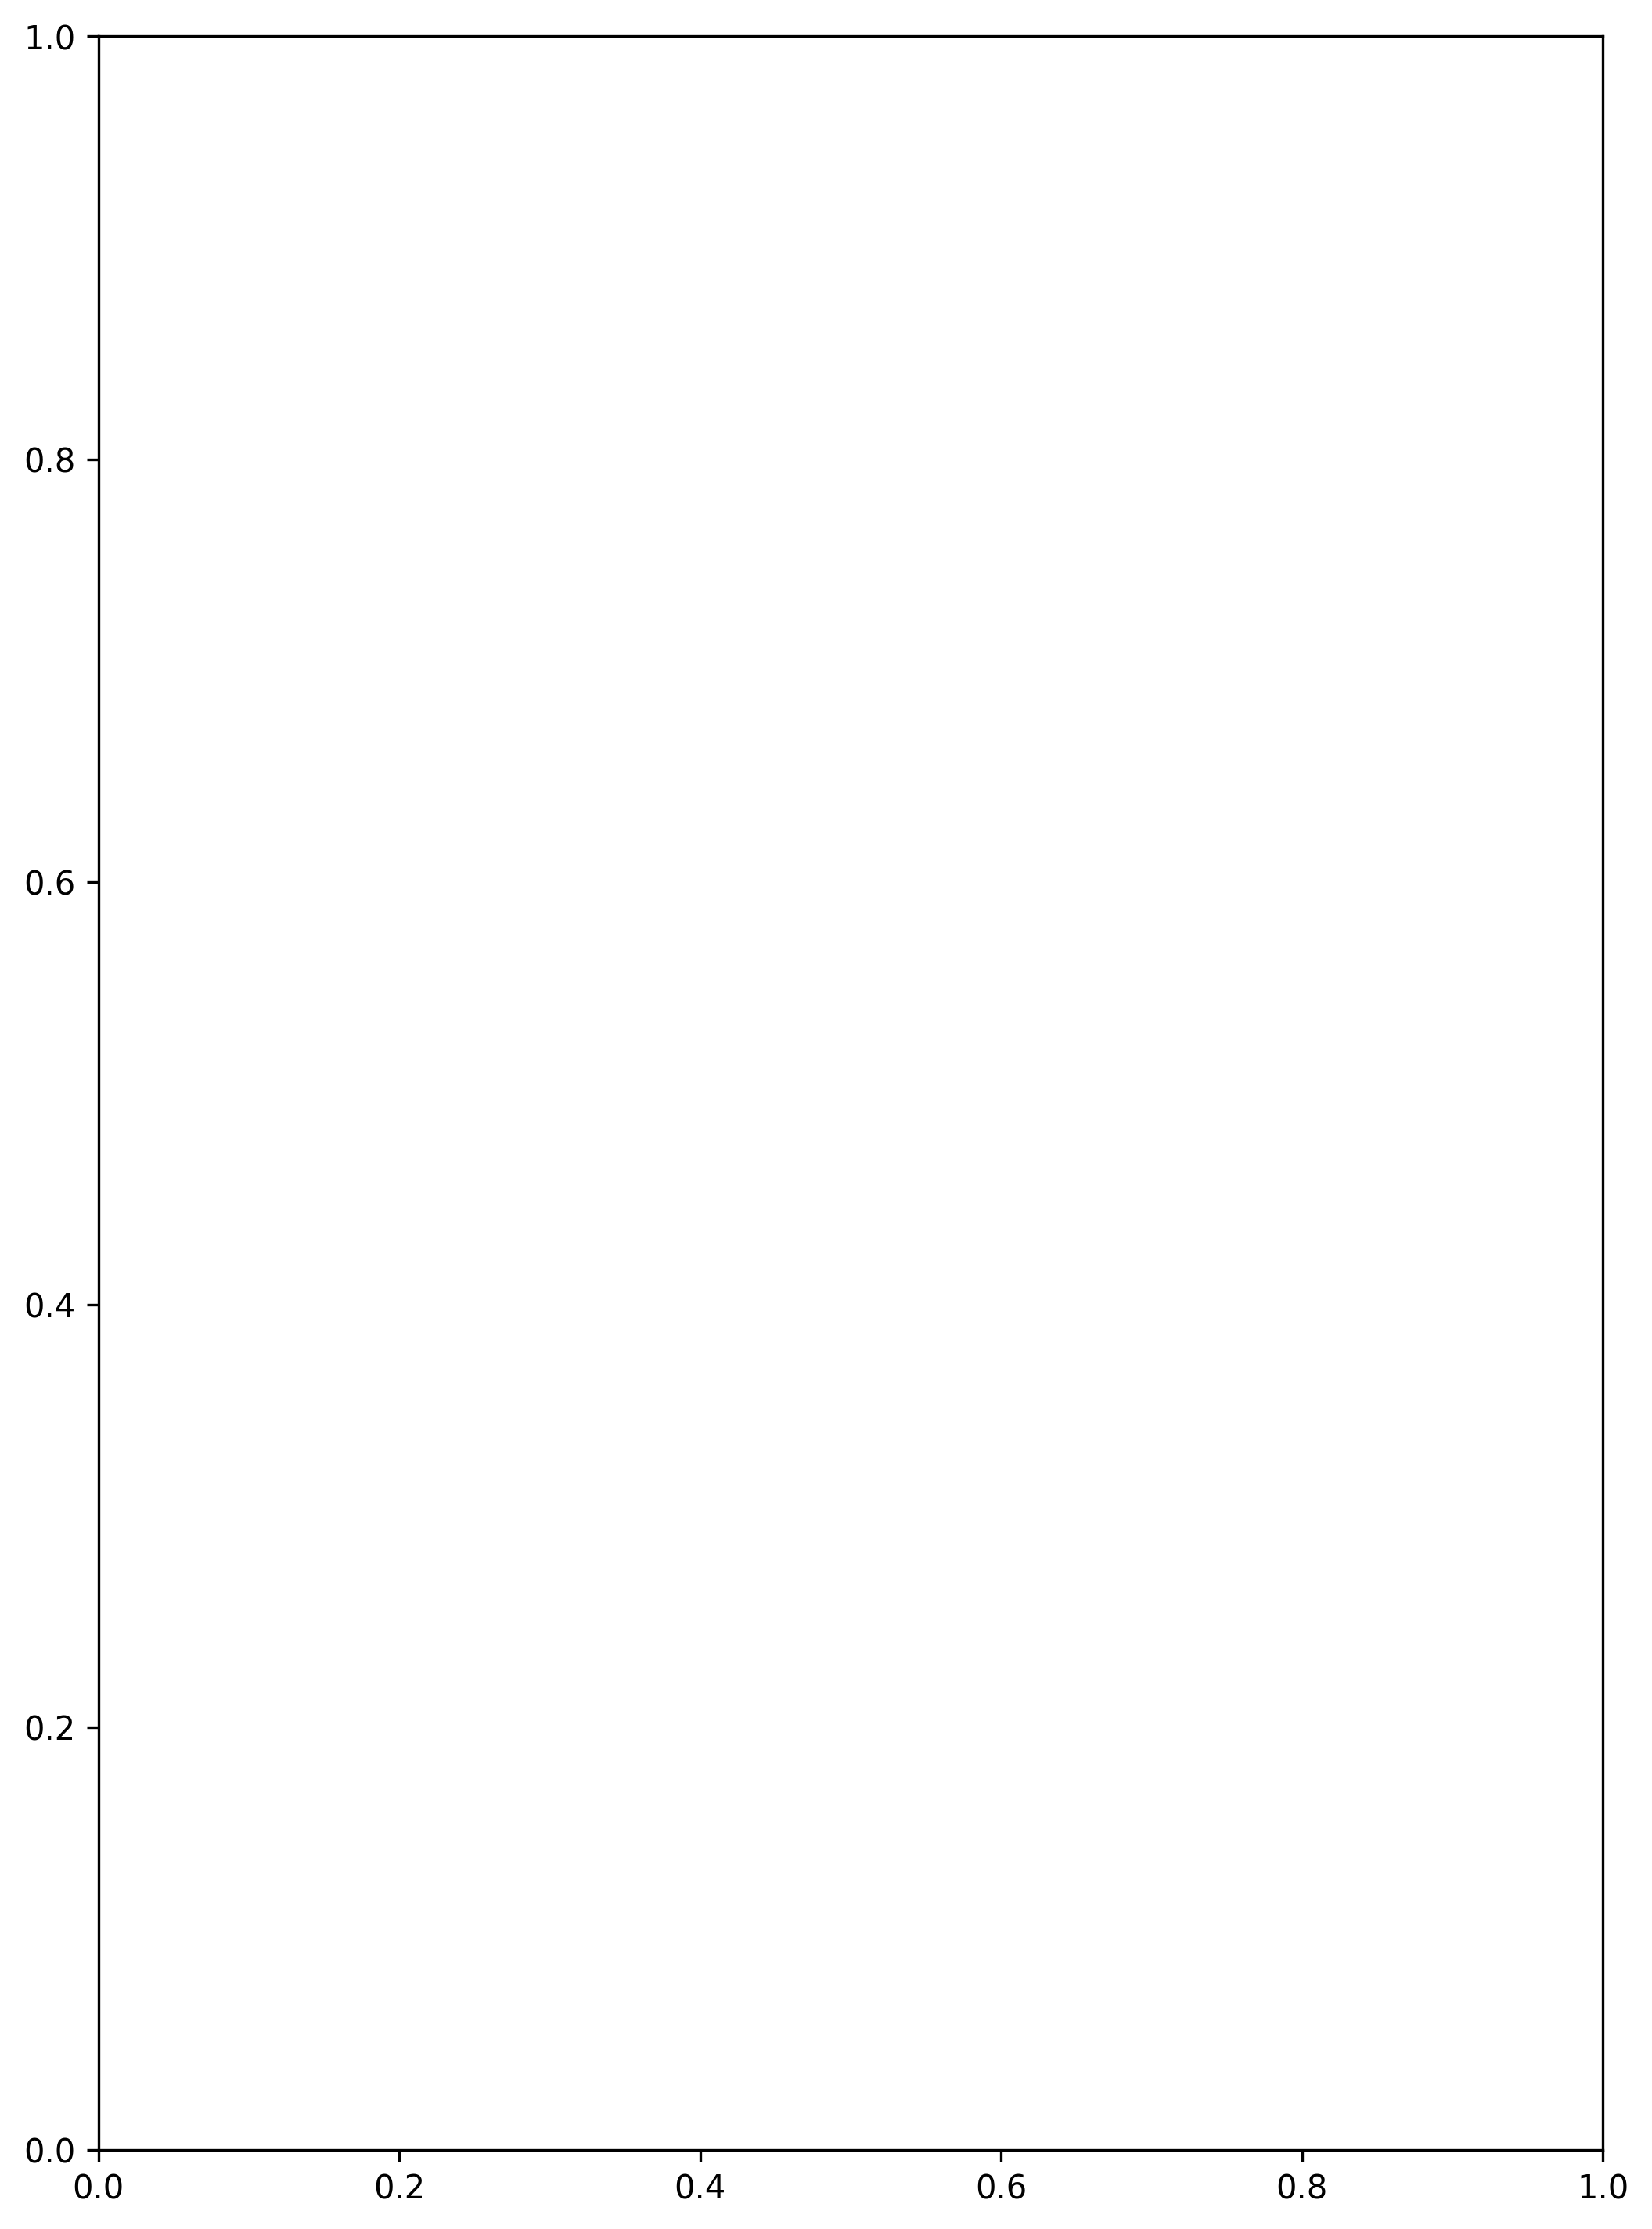

In [8]:
fig, ax = plt.subplots(figsize=(8.27, 11.69), dpi=300)  


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

dedup_df['timestamp_float'] = mdates.date2num(dedup_df.index.to_pydatetime())

plt.figure(figsize=(12, 6))

sns.kdeplot(dedup_df[dedup_df['isAnomaly']==0]['timestamp_float'], dedup_df[dedup_df['isAnomaly']==0]['node'], 
            cmap='Blues', shade=True, shade_lowest=False)

sns.kdeplot(dedup_df[dedup_df['isAnomaly']==1]['timestamp_float'], dedup_df[dedup_df['isAnomaly']==1]['node'], 
            cmap='Reds', shade=True, shade_lowest=False)

x_ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels([mdates.num2date(tick).strftime('%Y-%m-%d') for tick in x_ticks], rotation=45)

plt.title('Anomaly Detection KDE Plot')
plt.xlabel('Date')
plt.ylabel('Node')

plt.show()


/tmp/ipykernel_2062307/638339799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dedup_df['timestamp_float'] = mdates.date2num(dedup_df.index.to_pydatetime())


: 

: 

<Axes: xlabel='node', ylabel='timestamp'>

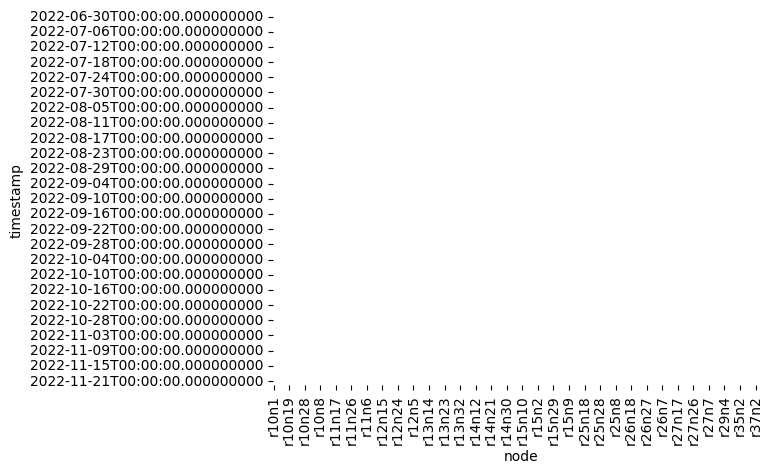

In [23]:
anomaly_df = pivot_df[pivot_df == 1]

sns.heatmap(anomaly_df, cmap=['white', 'red'], cbar=False, linewidths=.5)

In [18]:
dedup_df

,node,node_load15,node_load5,node_load1,node_memory_Active_bytes,node_filesystem_device_error-sum,node_netstat_Icmp_InErrors,node_netstat_Tcp_InErrs,node_netstat_Udp_InErrors,nvidia_gpu_power_usage_milliwatts-max,nvidia_gpu_temperature_celsius-max,isAnomaly
timestamp,,,,,,,,,,,,
2022-06-30 16:00:30,r10n1,15.38,15.39,15.43,1.221620e+10,0.0,2798.0,3.0,0.0,0.0,0.0,0
2022-06-30 16:00:30,r10n10,10.33,10.49,10.60,4.038920e+09,0.0,1.0,0.0,0.0,0.0,0.0,0
2022-06-30 16:00:30,r10n11,6.76,8.41,10.39,3.563060e+10,0.0,6.0,0.0,0.0,0.0,0.0,0
2022-06-30 16:00:30,r10n12,6.75,7.28,6.93,3.298280e+10,0.0,0.0,0.0,0.0,0.0,0.0,0
2022-06-30 16:00:30,r10n13,7.23,6.91,7.40,8.767090e+09,0.0,4.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-22 11:20:30,r37n4,0.00,0.04,0.08,1.041050e+09,0.0,0.0,0.0,0.0,0.0,0.0,0
2022-11-22 11:20:30,r37n6,0.01,0.05,0.10,1.007960e+09,0.0,0.0,0.0,0.0,0.0,0.0,0
2022-11-22 11:20:30,r38n2,0.01,0.04,0.01,1.504280e+09,0.0,0.0,0.0,0.0,34839.0,35.0,0


In [12]:
grouped = prom_df.groupby(['timestamp', 'node']).size()

duplicates = grouped[grouped > 1]

print(duplicates)

timestamp            node  
2022-10-30 01:00:00  r10n1     2
                     r10n10    2
                     r10n11    2
                     r10n12    2
                     r10n13    2
                              ..
2022-10-30 01:59:30  r37n6     2
                     r38n1     2
                     r38n2     2
                     r38n3     2
                     r38n4     2
Length: 38160, dtype: int64


In [13]:
duplicate_rows = prom_df[prom_df.duplicated(subset=['timestamp', 'node'], keep=False)]

print(duplicate_rows)


                    timestamp    node  node_load15  node_load5  node_load1  \
94396     2022-10-30 01:00:00  r12n20        16.32       16.10       16.08   
94397     2022-10-30 01:00:00  r12n20        17.11       16.07       16.12   
94398     2022-10-30 01:00:30  r12n20        16.31       16.09       16.05   
94399     2022-10-30 01:00:30  r12n20        17.08       16.08       16.15   
94400     2022-10-30 01:01:00  r12n20        16.30       16.08       16.03   
...                       ...     ...          ...         ...         ...   
123450054 2022-10-30 01:58:30   r36n2        20.98       23.84       24.01   
123450055 2022-10-30 01:59:00   r36n2        17.85       20.95       24.05   
123450056 2022-10-30 01:59:00   r36n2        21.09       23.90       24.17   
123450057 2022-10-30 01:59:30   r36n2        18.05       21.24       24.03   
123450058 2022-10-30 01:59:30   r36n2        21.20       23.98       24.38   

           node_memory_Active_bytes  node_filesystem_device_err

In [5]:
sorted_df = prom_df.sort_values(by=['timestamp', 'node', 'isAnomaly'], ascending=[True, True, False])
dedup_df = sorted_df.drop_duplicates(subset=['timestamp', 'node'])
